In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import concatenate
from math import sqrt
from statistics import mean
import random
import matplotlib.pyplot as plt

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/Users/alexellard/Downloads/scenarios_data.csv', header=0, index_col=0)
df

,reservoir_demand,node_1_demand,node_2_demand,node_3_demand,node_4_demand,node_5_demand,node_6_demand,node_7_demand,node_8_demand,node_9_demand,...,link_23_flow,link_24_flow,link_25_flow,link_26_flow,link_27_flow,link_28_flow,link_29_flow,link_30_flow,link_31_flow,link_32_flow
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-3348.0,154.8,169.2,18.0,118.8,169.2,234.0,86.4,82.8,104.4,...,439.2,-205.2,-75.6,-18.0,118.8,68.4,7.2,-54.0,75.6,212.4
2017-01-01 00:30:00,-2959.2,136.8,147.6,18.0,108.0,144.0,237.6,79.2,75.6,90.0,...,392.4,-187.2,-72.0,-21.6,108.0,61.2,3.6,-54.0,72.0,183.6
2017-01-01 01:00:00,-2692.8,129.6,126.0,14.4,104.4,133.2,205.2,72.0,72.0,90.0,...,349.2,-176.4,-64.8,-18.0,93.6,50.4,3.6,-39.6,54.0,151.2
2017-01-01 01:30:00,-2379.6,104.4,100.8,10.8,86.4,122.4,180.0,68.4,57.6,82.8,...,316.8,-158.4,-54.0,-10.8,79.2,46.8,7.2,-32.4,50.4,140.4
2017-01-01 02:00:00,-2228.4,104.4,104.4,10.8,79.2,122.4,183.6,68.4,54.0,75.6,...,277.2,-144.0,-57.6,-18.0,72.0,39.6,7.2,-32.4,43.2,118.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:30:00,-5306.4,205.2,208.8,39.6,183.6,284.4,316.8,176.4,133.2,129.6,...,604.8,-259.2,32.4,115.2,169.2,100.8,10.8,-100.8,122.4,309.6
2017-12-31 22:00:00,-4910.4,208.8,183.6,39.6,154.8,252.0,295.2,165.6,133.2,133.2,...,565.2,-241.2,21.6,100.8,154.8,86.4,18.0,-75.6,100.8,288.0
2017-12-31 22:30:00,-4683.6,187.2,183.6,36.0,147.6,230.4,320.4,147.6,118.8,126.0,...,529.2,-226.8,21.6,100.8,147.6,86.4,14.4,-86.4,108.0,266.4


In [3]:
#average scores pressure node 16

MAE_average = []
RMSE_average = []
R2_average = []
maximum_MAE = []
sensors_covered = []
n_columns_to_drop = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
for n in n_columns_to_drop:
    MAE = []
    RMSE = []
    R2 = []
    for run in range(1,11):
        Y = df[df.columns[48]]
        X = df.drop(columns=['node_16_pressure'])
        X['node_16_pressure'] = Y
        columns = []
        columns_to_drop = random.sample(list(X.columns), n)
        # Drop the selected columns from the dataframe
        if X.columns[-1] in columns_to_drop:
            columns_to_drop.remove(X.columns[-1])
        X.drop(columns_to_drop, axis=1, inplace=True)
        columns.append(columns_to_drop)
        print(columns)
        print('starting df shape:', X.shape)
        print(f'This is training run {run} and has the shape: ', X.shape)
        print(f'The value of dropped columns is {n}')

        values = X.values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        scaled = scaler.fit_transform(values)
        train, test = train_test_split(scaled, test_size=0.2, random_state=0)

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        #define model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42
        )

        # fit the model on the training data
        model.fit(train_X, train_y)

        # make predictions on the test data
        y_pred = model.predict(test_X)

        test_y = test_y.reshape((len(test_y), 1))
        print('test y shape :', test_y.shape)
        inv_test_y = concatenate((test_y, test_X[:, -X.shape[1]:]), axis=1)
        print('Inv y shape :', inv_test_y.shape)
        test_y_inverse = scaler.inverse_transform(inv_test_y)
        test_y_inverse = test_y_inverse[:,0]

        y_pred = y_pred.reshape((len(y_pred), 1))
        print('y pred shape :', y_pred.shape)
        inv_y_pred = concatenate((y_pred, test_X[:, -X.shape[1]:]), axis=1)
        print('inv y pred :', inv_y_pred.shape)
        y_pred_inverse = scaler.inverse_transform(inv_y_pred)
        y_pred_inverse = y_pred_inverse[:,0]

        # evaluate scaled errors
        mae_inverse = mean_absolute_error(test_y_inverse, y_pred_inverse)
        MAE.append(mae_inverse)
        print(f'Run {run} Mean Absolute Error:', mae_inverse)
        rmse_inverse = sqrt(mean_squared_error(test_y_inverse, y_pred_inverse))
        RMSE.append(rmse_inverse)
        print('RMSE: %.3f' % rmse_inverse)
        r2_inverse = r2_score(test_y_inverse, y_pred_inverse)
        R2.append(r2_inverse)
        print('R^2: %.3f' % r2_inverse)
    percentage_list = round(X.shape[1] / 96 * 100)
    sensors_covered.append(percentage_list)
    MAE_mean = mean(MAE)
    RMSE_mean = mean(RMSE)
    R2_mean = mean(R2)
    max_MAE = max(MAE)
    maximum_MAE.append(max_MAE)
    MAE_average.append(MAE_mean)
    RMSE_average.append(RMSE_mean)
    R2_average.append(R2_mean)
print('Length MAE_average: ', len(MAE_average))
print('Length sensors_covered: ', len(sensors_covered))

[[]]
starting df shape: (87600, 96)
This is training run 1 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 1 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 2 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 2 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 3 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 3 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 4 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 4 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 5 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 5 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 6 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 6 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 7 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 7 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 8 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 8 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 9 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 9 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[[]]
starting df shape: (87600, 96)
This is training run 10 and has the shape:  (87600, 96)
The value of dropped columns is 0


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 96)
y pred shape : (17520, 1)
inv y pred : (17520, 96)
Run 10 Mean Absolute Error: 7.354637090832215
RMSE: 10.219
R^2: 1.000
[['node_21_pressure', 'node_11_demand', 'link_24_flow', 'link_12_flow', 'link_26_flow']]
starting df shape: (87600, 91)
This is training run 1 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 1 Mean Absolute Error: 7.86278695818408
RMSE: 10.864
R^2: 1.000
[['node_22_pressure', 'link_29_flow', 'node_30_demand', 'link_17_flow', 'node_12_pressure']]
starting df shape: (87600, 91)
This is training run 2 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 2 Mean Absolute Error: 7.5118291458615465
RMSE: 10.607
R^2: 1.000
[['node_9_demand', 'node_2_pressure', 'node_8_pressure', 'link_16_flow', 'link_26_flow']]
starting df shape: (87600, 91)
This is training run 3 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 3 Mean Absolute Error: 7.854166365539749
RMSE: 11.110
R^2: 1.000
[['node_2_pressure', 'link_27_flow', 'node_21_pressure', 'link_25_flow', 'link_4_flow']]
starting df shape: (87600, 91)
This is training run 4 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 4 Mean Absolute Error: 7.813123011442837
RMSE: 10.825
R^2: 1.000
[['reservoir_pressure', 'link_22_flow', 'node_24_demand', 'node_22_pressure', 'node_12_pressure']]
starting df shape: (87600, 91)
This is training run 5 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 5 Mean Absolute Error: 7.567755637770531
RMSE: 10.794
R^2: 1.000
[['node_10_demand', 'link_31_flow', 'node_29_demand', 'node_7_pressure', 'node_28_pressure']]
starting df shape: (87600, 91)
This is training run 6 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 6 Mean Absolute Error: 7.830318338067414
RMSE: 11.061
R^2: 1.000
[['link_9_flow', 'link_26_flow', 'node_13_pressure', 'node_30_demand', 'node_13_demand']]
starting df shape: (87600, 91)
This is training run 7 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 7 Mean Absolute Error: 7.554388958492593
RMSE: 10.520
R^2: 1.000
[['link_28_flow', 'node_21_demand', 'node_22_pressure', 'link_23_flow', 'link_22_flow']]
starting df shape: (87600, 91)
This is training run 8 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 8 Mean Absolute Error: 7.753423580363137
RMSE: 10.818
R^2: 1.000
[['node_12_demand', 'node_19_pressure', 'node_5_demand', 'link_6_flow', 'node_30_pressure']]
starting df shape: (87600, 91)
This is training run 9 and has the shape:  (87600, 91)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 91)
y pred shape : (17520, 1)
inv y pred : (17520, 91)
Run 9 Mean Absolute Error: 7.96115285922161
RMSE: 11.184
R^2: 1.000
[['node_9_demand', 'link_22_flow', 'node_15_pressure', 'node_21_demand']]
starting df shape: (87600, 92)
This is training run 10 and has the shape:  (87600, 92)
The value of dropped columns is 5


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 92)
y pred shape : (17520, 1)
inv y pred : (17520, 92)
Run 10 Mean Absolute Error: 7.910602239593714
RMSE: 10.804
R^2: 1.000
[['node_14_demand', 'link_26_flow', 'node_5_pressure', 'node_15_pressure', 'node_3_pressure', 'node_22_demand', 'node_1_demand', 'link_12_flow', 'node_8_pressure']]
starting df shape: (87600, 87)
This is training run 1 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 1 Mean Absolute Error: 8.2295339485561
RMSE: 11.404
R^2: 1.000
[['link_25_flow', 'link_16_flow', 'node_22_demand', 'link_6_flow', 'node_15_demand', 'node_30_demand', 'node_1_pressure', 'link_22_flow', 'link_10_flow', 'node_19_demand']]
starting df shape: (87600, 86)
This is training run 2 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 2 Mean Absolute Error: 7.713926858480741
RMSE: 10.659
R^2: 1.000
[['node_8_demand', 'node_18_pressure', 'node_21_demand', 'node_26_demand', 'link_31_flow', 'reservoir_pressure', 'node_31_demand', 'link_9_flow', 'node_14_demand', 'node_28_pressure']]
starting df shape: (87600, 86)
This is training run 3 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 3 Mean Absolute Error: 7.573620295474779
RMSE: 10.490
R^2: 1.000
[['node_27_pressure', 'node_8_demand', 'node_11_demand', 'node_9_pressure', 'link_2_flow', 'link_8_flow', 'node_27_demand', 'node_17_demand', 'node_21_pressure', 'node_26_demand']]
starting df shape: (87600, 86)
This is training run 4 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 4 Mean Absolute Error: 7.768668145921828
RMSE: 10.855
R^2: 1.000
[['link_20_flow', 'node_12_pressure', 'link_30_flow', 'node_1_demand', 'node_23_pressure', 'node_18_pressure', 'link_12_flow', 'node_27_demand', 'node_13_demand']]
starting df shape: (87600, 87)
This is training run 5 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 5 Mean Absolute Error: 7.3760830227861724
RMSE: 10.524
R^2: 1.000
[['node_15_pressure', 'node_9_demand', 'link_25_flow', 'node_23_demand', 'node_10_pressure', 'link_29_flow', 'node_26_demand', 'node_11_pressure', 'node_14_demand']]
starting df shape: (87600, 87)
This is training run 6 and has the shape:  (87600, 87)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 87)
y pred shape : (17520, 1)
inv y pred : (17520, 87)
Run 6 Mean Absolute Error: 7.976542506747127
RMSE: 10.876
R^2: 1.000
[['node_10_demand', 'link_27_flow', 'node_18_pressure', 'node_30_demand', 'link_30_flow', 'node_2_pressure', 'node_4_pressure', 'node_20_demand', 'node_20_pressure', 'node_31_demand']]
starting df shape: (87600, 86)
This is training run 7 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 7 Mean Absolute Error: 7.531447989824018
RMSE: 10.337
R^2: 1.000
[['node_16_demand', 'node_22_pressure', 'node_22_demand', 'node_26_pressure', 'node_15_pressure', 'link_3_flow', 'link_17_flow', 'link_13_flow', 'reservoir_pressure', 'node_28_pressure']]
starting df shape: (87600, 86)
This is training run 8 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 8 Mean Absolute Error: 8.454624566296378
RMSE: 11.642
R^2: 1.000
[['node_25_pressure', 'node_25_demand', 'node_1_demand', 'node_24_pressure', 'node_15_demand', 'node_11_demand', 'reservoir_demand', 'node_14_demand', 'node_8_demand', 'link_32_flow']]
starting df shape: (87600, 86)
This is training run 9 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 9 Mean Absolute Error: 0.41266665096434746
RMSE: 0.575
R^2: 1.000
[['node_14_pressure', 'node_21_pressure', 'reservoir_pressure', 'link_3_flow', 'node_30_pressure', 'node_11_demand', 'node_23_pressure', 'node_4_demand', 'node_7_pressure', 'node_2_pressure']]
starting df shape: (87600, 86)
This is training run 10 and has the shape:  (87600, 86)
The value of dropped columns is 10


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 86)
y pred shape : (17520, 1)
inv y pred : (17520, 86)
Run 10 Mean Absolute Error: 7.665671139331386
RMSE: 10.611
R^2: 1.000
[['node_27_pressure', 'node_10_pressure', 'link_10_flow', 'link_24_flow', 'node_13_demand', 'node_15_pressure', 'link_9_flow', 'link_32_flow', 'link_15_flow', 'link_22_flow', 'node_2_demand', 'link_23_flow', 'node_6_pressure', 'link_13_flow', 'node_30_pressure']]
starting df shape: (87600, 81)
This is training run 1 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 1 Mean Absolute Error: 8.548500474267975
RMSE: 11.718
R^2: 1.000
[['link_16_flow', 'node_9_pressure', 'link_15_flow', 'node_10_pressure', 'node_8_demand', 'node_1_demand', 'link_5_flow', 'node_2_demand', 'link_30_flow', 'node_18_pressure', 'node_20_demand', 'link_32_flow', 'node_23_pressure', 'link_20_flow']]
starting df shape: (87600, 82)
This is training run 2 and has the shape:  (87600, 82)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 82)
y pred shape : (17520, 1)
inv y pred : (17520, 82)
Run 2 Mean Absolute Error: 8.101313219397772
RMSE: 11.210
R^2: 1.000
[['node_7_pressure', 'node_1_demand', 'node_5_pressure', 'node_20_pressure', 'node_26_demand', 'link_29_flow', 'link_30_flow', 'node_18_pressure', 'node_12_pressure', 'link_11_flow', 'node_17_demand', 'node_31_demand', 'link_22_flow', 'link_14_flow', 'node_24_pressure']]
starting df shape: (87600, 81)
This is training run 3 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 3 Mean Absolute Error: 7.327671864369494
RMSE: 10.337
R^2: 1.000
[['node_30_demand', 'link_1_flow', 'node_24_pressure', 'node_18_demand', 'node_30_pressure', 'link_5_flow', 'link_20_flow', 'link_30_flow', 'link_10_flow', 'link_3_flow', 'node_23_pressure', 'node_1_pressure', 'node_20_demand', 'node_10_demand', 'link_7_flow']]
starting df shape: (87600, 81)
This is training run 4 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 4 Mean Absolute Error: 7.66268922224476
RMSE: 10.659
R^2: 1.000
[['node_13_demand', 'link_25_flow', 'link_28_flow', 'node_31_demand', 'link_4_flow', 'node_23_demand', 'link_17_flow', 'node_26_demand', 'node_8_pressure', 'node_13_pressure', 'node_5_demand', 'link_26_flow', 'link_30_flow', 'node_7_demand', 'node_28_pressure']]
starting df shape: (87600, 81)
This is training run 5 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 5 Mean Absolute Error: 7.71350630480561
RMSE: 10.797
R^2: 1.000
[['node_20_demand', 'node_8_demand', 'node_2_demand', 'node_11_demand', 'node_4_demand', 'node_9_demand', 'node_28_pressure', 'node_29_pressure', 'node_3_pressure', 'link_28_flow', 'node_19_demand', 'node_22_pressure', 'reservoir_demand', 'link_23_flow', 'node_14_pressure']]
starting df shape: (87600, 81)
This is training run 6 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 6 Mean Absolute Error: 0.4738510381473309
RMSE: 0.663
R^2: 1.000
[['link_10_flow', 'link_6_flow', 'node_10_pressure', 'node_17_demand', 'node_19_pressure', 'node_29_pressure', 'node_24_demand', 'node_5_demand', 'node_8_demand', 'link_26_flow', 'link_4_flow', 'node_21_pressure', 'node_7_demand', 'node_23_pressure', 'node_23_demand']]
starting df shape: (87600, 81)
This is training run 7 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 7 Mean Absolute Error: 7.651784687549431
RMSE: 10.706
R^2: 1.000
[['node_8_demand', 'link_24_flow', 'node_26_demand', 'node_24_pressure', 'node_11_pressure', 'reservoir_pressure', 'node_18_demand', 'node_13_pressure', 'node_23_demand', 'node_17_demand', 'link_13_flow', 'node_13_demand', 'node_4_pressure', 'link_28_flow', 'node_21_pressure']]
starting df shape: (87600, 81)
This is training run 8 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 8 Mean Absolute Error: 7.700416784148552
RMSE: 10.744
R^2: 1.000
[['link_32_flow', 'node_7_demand', 'node_25_demand', 'node_21_demand', 'link_7_flow', 'node_5_pressure', 'node_20_pressure', 'link_5_flow', 'node_5_demand', 'link_22_flow', 'node_14_demand', 'node_17_pressure', 'node_15_demand', 'node_2_demand', 'node_4_demand']]
starting df shape: (87600, 81)
This is training run 9 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 9 Mean Absolute Error: 7.986047675257628
RMSE: 11.025
R^2: 1.000
[['reservoir_pressure', 'node_3_demand', 'node_18_demand', 'node_21_pressure', 'node_2_pressure', 'node_27_pressure', 'link_25_flow', 'link_32_flow', 'node_7_demand', 'link_16_flow', 'link_7_flow', 'link_24_flow', 'node_8_pressure', 'node_8_demand', 'node_25_demand']]
starting df shape: (87600, 81)
This is training run 10 and has the shape:  (87600, 81)
The value of dropped columns is 15


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 81)
y pred shape : (17520, 1)
inv y pred : (17520, 81)
Run 10 Mean Absolute Error: 7.655927115690882
RMSE: 10.548
R^2: 1.000
[['link_13_flow', 'link_32_flow', 'link_14_flow', 'link_8_flow', 'link_15_flow', 'link_27_flow', 'node_8_pressure', 'node_7_demand', 'link_12_flow', 'node_10_demand', 'node_5_pressure', 'link_21_flow', 'link_26_flow', 'link_18_flow', 'node_27_demand', 'node_3_demand', 'link_3_flow', 'node_15_pressure', 'node_29_demand']]
starting df shape: (87600, 77)
This is training run 1 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 1 Mean Absolute Error: 8.662483750318628
RMSE: 12.124
R^2: 1.000
[['node_24_demand', 'link_11_flow', 'node_8_pressure', 'node_22_demand', 'node_12_demand', 'node_4_pressure', 'node_10_demand', 'node_31_demand', 'node_27_pressure', 'node_27_demand', 'link_22_flow', 'node_26_demand', 'link_24_flow', 'node_25_demand', 'node_10_pressure', 'node_1_demand', 'node_23_demand', 'node_6_pressure', 'node_26_pressure', 'link_14_flow']]
starting df shape: (87600, 76)
This is training run 2 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 2 Mean Absolute Error: 7.789437609574196
RMSE: 11.016
R^2: 1.000
[['link_8_flow', 'node_4_demand', 'node_1_pressure', 'node_10_demand', 'link_26_flow', 'link_19_flow', 'node_25_pressure', 'node_3_pressure', 'link_27_flow', 'node_2_pressure', 'link_6_flow', 'node_30_demand', 'node_28_demand', 'node_16_demand', 'node_1_demand', 'node_8_pressure', 'reservoir_pressure', 'link_18_flow', 'node_19_demand', 'node_19_pressure']]
starting df shape: (87600, 76)
This is training run 3 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 3 Mean Absolute Error: 8.286290828993573
RMSE: 11.469
R^2: 1.000
[['node_9_pressure', 'node_8_pressure', 'link_20_flow', 'node_28_demand', 'node_18_pressure', 'node_23_demand', 'link_31_flow', 'node_13_pressure', 'link_7_flow', 'node_14_demand', 'node_23_pressure', 'node_24_pressure', 'node_3_pressure', 'node_13_demand', 'node_25_demand', 'link_30_flow', 'node_1_pressure', 'link_32_flow', 'link_26_flow']]
starting df shape: (87600, 77)
This is training run 4 and has the shape:  (87600, 77)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 77)
y pred shape : (17520, 1)
inv y pred : (17520, 77)
Run 4 Mean Absolute Error: 7.887781787240417
RMSE: 10.960
R^2: 1.000
[['link_27_flow', 'node_1_pressure', 'link_14_flow', 'node_2_pressure', 'node_13_pressure', 'link_31_flow', 'node_7_pressure', 'reservoir_demand', 'link_28_flow', 'node_15_pressure', 'node_30_pressure', 'node_22_demand', 'node_17_demand', 'link_6_flow', 'node_9_demand', 'node_18_pressure', 'node_21_pressure', 'node_6_demand', 'link_5_flow', 'link_2_flow']]
starting df shape: (87600, 76)
This is training run 5 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 5 Mean Absolute Error: 0.49993839689942043
RMSE: 0.686
R^2: 1.000
[['link_26_flow', 'node_3_demand', 'link_8_flow', 'link_5_flow', 'link_4_flow', 'node_21_pressure', 'link_22_flow', 'node_21_demand', 'node_7_pressure', 'node_8_pressure', 'node_6_pressure', 'node_3_pressure', 'link_10_flow', 'link_19_flow', 'node_2_demand', 'link_15_flow', 'link_31_flow', 'node_5_demand', 'node_10_pressure', 'link_14_flow']]
starting df shape: (87600, 76)
This is training run 6 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 6 Mean Absolute Error: 8.093491578246656
RMSE: 11.309
R^2: 1.000
[['node_29_demand', 'link_23_flow', 'node_31_pressure', 'node_4_pressure', 'node_31_demand', 'node_10_pressure', 'link_4_flow', 'link_27_flow', 'node_7_pressure', 'link_1_flow', 'node_11_pressure', 'node_25_demand', 'link_10_flow', 'link_2_flow', 'node_14_pressure', 'node_21_demand', 'node_23_demand', 'node_10_demand', 'node_12_pressure', 'node_9_demand']]
starting df shape: (87600, 76)
This is training run 7 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 7 Mean Absolute Error: 7.653018124606804
RMSE: 11.095
R^2: 1.000
[['node_21_pressure', 'node_28_demand', 'node_15_pressure', 'node_14_demand', 'node_17_pressure', 'node_10_demand', 'node_7_pressure', 'node_1_pressure', 'link_1_flow', 'link_16_flow', 'node_13_demand', 'link_26_flow', 'link_11_flow', 'node_5_pressure', 'link_10_flow', 'reservoir_pressure', 'node_18_demand', 'node_2_pressure', 'node_9_demand', 'node_16_demand']]
starting df shape: (87600, 76)
This is training run 8 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 8 Mean Absolute Error: 10.018263864430903
RMSE: 13.853
R^2: 1.000
[['link_32_flow', 'link_16_flow', 'link_15_flow', 'node_31_demand', 'link_18_flow', 'node_15_demand', 'link_5_flow', 'node_11_demand', 'node_13_demand', 'node_15_pressure', 'link_6_flow', 'node_27_pressure', 'node_28_demand', 'node_30_demand', 'node_30_pressure', 'link_28_flow', 'link_10_flow', 'node_21_demand', 'node_22_pressure', 'link_19_flow']]
starting df shape: (87600, 76)
This is training run 9 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 9 Mean Absolute Error: 8.346445462655767
RMSE: 11.645
R^2: 1.000
[['node_29_demand', 'node_8_pressure', 'node_11_pressure', 'node_31_demand', 'node_26_demand', 'node_23_pressure', 'link_28_flow', 'node_5_pressure', 'node_15_pressure', 'link_9_flow', 'link_19_flow', 'link_4_flow', 'node_27_pressure', 'node_31_pressure', 'node_21_pressure', 'node_30_pressure', 'node_6_pressure', 'link_11_flow', 'node_10_demand', 'node_13_pressure']]
starting df shape: (87600, 76)
This is training run 10 and has the shape:  (87600, 76)
The value of dropped columns is 20


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 76)
y pred shape : (17520, 1)
inv y pred : (17520, 76)
Run 10 Mean Absolute Error: 8.109691300649255
RMSE: 11.178
R^2: 1.000
[['node_31_pressure', 'node_20_demand', 'node_12_pressure', 'node_28_demand', 'node_31_demand', 'link_28_flow', 'link_8_flow', 'node_30_demand', 'link_20_flow', 'link_12_flow', 'node_18_pressure', 'node_4_pressure', 'node_3_demand', 'node_27_demand', 'link_7_flow', 'node_25_demand', 'node_8_demand', 'node_22_demand', 'node_21_pressure', 'link_3_flow', 'node_6_pressure', 'link_26_flow', 'link_30_flow', 'reservoir_pressure', 'node_23_demand']]
starting df shape: (87600, 71)
This is training run 1 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 1 Mean Absolute Error: 7.250776853616289
RMSE: 10.092
R^2: 1.000
[['link_2_flow', 'link_23_flow', 'link_25_flow', 'node_24_demand', 'node_25_pressure', 'node_2_demand', 'link_29_flow', 'link_12_flow', 'node_21_pressure', 'node_6_demand', 'node_11_pressure', 'link_27_flow', 'node_10_demand', 'node_8_demand', 'node_2_pressure', 'link_14_flow', 'link_19_flow', 'node_29_pressure', 'node_4_demand', 'node_1_demand', 'reservoir_pressure', 'link_26_flow', 'link_1_flow', 'link_32_flow', 'node_23_demand']]
starting df shape: (87600, 71)
This is training run 2 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 2 Mean Absolute Error: 7.743104602431052
RMSE: 10.715
R^2: 1.000
[['node_3_pressure', 'node_31_demand', 'link_2_flow', 'node_10_pressure', 'node_1_pressure', 'node_4_demand', 'node_17_pressure', 'node_31_pressure', 'node_12_pressure', 'node_21_demand', 'node_5_pressure', 'node_6_demand', 'link_7_flow', 'link_1_flow', 'node_30_pressure', 'node_13_demand', 'node_11_pressure', 'link_13_flow', 'link_16_flow', 'link_12_flow', 'link_27_flow', 'node_25_demand', 'link_20_flow', 'link_25_flow', 'link_29_flow']]
starting df shape: (87600, 71)
This is training run 3 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 3 Mean Absolute Error: 7.849671742092946
RMSE: 11.107
R^2: 1.000
[['node_19_pressure', 'node_13_pressure', 'link_26_flow', 'node_14_pressure', 'node_10_demand', 'node_5_demand', 'node_22_pressure', 'link_7_flow', 'link_2_flow', 'reservoir_pressure', 'link_29_flow', 'node_31_pressure', 'reservoir_demand', 'link_31_flow', 'node_30_pressure', 'node_9_demand', 'node_17_demand', 'node_22_demand', 'link_6_flow', 'node_29_demand', 'node_30_demand', 'link_25_flow', 'node_7_demand', 'link_28_flow', 'node_17_pressure']]
starting df shape: (87600, 71)
This is training run 4 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 4 Mean Absolute Error: 0.4914314694038527
RMSE: 0.688
R^2: 1.000
[['node_29_pressure', 'node_3_demand', 'node_24_pressure', 'node_30_pressure', 'node_29_demand', 'link_15_flow', 'node_7_pressure', 'node_15_demand', 'node_31_demand', 'link_28_flow', 'node_5_pressure', 'link_24_flow', 'link_30_flow', 'node_28_demand', 'node_23_demand', 'node_27_pressure', 'link_19_flow', 'link_12_flow', 'link_20_flow', 'node_10_pressure', 'node_7_demand', 'link_22_flow', 'node_17_demand', 'node_9_pressure', 'link_11_flow']]
starting df shape: (87600, 71)
This is training run 5 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 5 Mean Absolute Error: 8.032389935915784
RMSE: 11.326
R^2: 1.000
[['link_13_flow', 'node_24_demand', 'node_14_demand', 'link_23_flow', 'link_18_flow', 'node_2_pressure', 'node_21_demand', 'link_21_flow', 'link_27_flow', 'link_29_flow', 'link_4_flow', 'node_4_pressure', 'link_12_flow', 'node_4_demand', 'link_11_flow', 'link_28_flow', 'node_13_demand', 'link_6_flow', 'node_30_demand', 'link_17_flow', 'node_25_demand', 'link_32_flow', 'reservoir_pressure', 'node_12_pressure', 'node_20_demand']]
starting df shape: (87600, 71)
This is training run 6 and has the shape:  (87600, 71)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 71)
y pred shape : (17520, 1)
inv y pred : (17520, 71)
Run 6 Mean Absolute Error: 7.2642920017863615
RMSE: 10.299
R^2: 1.000
[['node_28_demand', 'link_32_flow', 'node_24_pressure', 'link_4_flow', 'node_26_pressure', 'node_29_demand', 'link_28_flow', 'node_11_pressure', 'node_15_pressure', 'node_4_pressure', 'node_20_demand', 'link_10_flow', 'node_18_pressure', 'link_15_flow', 'link_23_flow', 'link_7_flow', 'node_3_pressure', 'link_30_flow', 'node_26_demand', 'node_13_pressure', 'reservoir_pressure', 'link_22_flow', 'node_23_demand', 'link_17_flow']]
starting df shape: (87600, 72)
This is training run 7 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 7 Mean Absolute Error: 8.61336598643416
RMSE: 11.919
R^2: 1.000
[['node_12_pressure', 'node_10_pressure', 'node_10_demand', 'link_17_flow', 'node_15_pressure', 'link_26_flow', 'link_2_flow', 'node_19_demand', 'node_25_pressure', 'node_6_demand', 'node_17_demand', 'node_5_demand', 'node_14_demand', 'node_3_pressure', 'link_28_flow', 'link_31_flow', 'link_27_flow', 'link_4_flow', 'link_22_flow', 'node_29_pressure', 'link_18_flow', 'node_30_pressure', 'link_23_flow', 'node_29_demand']]
starting df shape: (87600, 72)
This is training run 8 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 8 Mean Absolute Error: 8.10122829800936
RMSE: 11.228
R^2: 1.000
[['node_15_demand', 'link_26_flow', 'node_11_demand', 'node_26_demand', 'link_4_flow', 'link_29_flow', 'node_18_pressure', 'node_29_demand', 'link_7_flow', 'node_4_pressure', 'link_22_flow', 'link_6_flow', 'node_13_pressure', 'link_12_flow', 'link_20_flow', 'node_16_demand', 'node_30_demand', 'node_15_pressure', 'link_27_flow', 'link_19_flow', 'link_16_flow', 'node_27_demand', 'link_17_flow', 'node_9_pressure']]
starting df shape: (87600, 72)
This is training run 9 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 9 Mean Absolute Error: 9.993591206041527
RMSE: 13.855
R^2: 1.000
[['link_5_flow', 'node_19_pressure', 'node_31_demand', 'link_23_flow', 'node_5_demand', 'link_13_flow', 'link_16_flow', 'node_8_demand', 'node_28_demand', 'node_25_pressure', 'reservoir_demand', 'node_22_demand', 'node_23_demand', 'link_19_flow', 'link_24_flow', 'node_24_demand', 'node_13_pressure', 'node_18_demand', 'node_9_demand', 'node_26_demand', 'node_11_pressure', 'link_9_flow', 'node_29_pressure', 'node_7_demand']]
starting df shape: (87600, 72)
This is training run 10 and has the shape:  (87600, 72)
The value of dropped columns is 25


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 72)
y pred shape : (17520, 1)
inv y pred : (17520, 72)
Run 10 Mean Absolute Error: 0.4583714998570337
RMSE: 0.634
R^2: 1.000
[['reservoir_demand', 'node_14_pressure', 'node_21_demand', 'node_5_pressure', 'link_7_flow', 'node_30_demand', 'node_30_pressure', 'link_17_flow', 'node_20_pressure', 'node_9_pressure', 'node_11_pressure', 'node_24_demand', 'node_1_pressure', 'node_22_demand', 'node_18_demand', 'node_27_demand', 'link_24_flow', 'node_29_demand', 'link_9_flow', 'link_14_flow', 'node_24_pressure', 'link_30_flow', 'node_21_pressure', 'link_25_flow', 'node_8_demand', 'node_12_pressure', 'node_23_demand', 'node_5_demand', 'node_1_demand', 'node_29_pressure']]
starting df shape: (87600, 66)
This is training run 1 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 1 Mean Absolute Error: 0.37781231968144635
RMSE: 0.534
R^2: 1.000
[['node_14_demand', 'node_24_pressure', 'link_32_flow', 'node_18_demand', 'node_10_demand', 'node_17_pressure', 'link_29_flow', 'link_7_flow', 'node_6_demand', 'node_23_pressure', 'node_22_pressure', 'node_19_demand', 'node_6_pressure', 'link_5_flow', 'link_24_flow', 'node_3_demand', 'node_30_demand', 'link_23_flow', 'node_11_pressure', 'reservoir_pressure', 'node_5_pressure', 'node_12_demand', 'node_27_pressure', 'link_11_flow', 'node_20_pressure', 'node_23_demand', 'node_3_pressure', 'node_29_demand', 'node_12_pressure', 'node_13_demand']]
starting df shape: (87600, 66)
This is training run 2 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 2 Mean Absolute Error: 7.509475940482619
RMSE: 10.643
R^2: 1.000
[['node_26_demand', 'link_2_flow', 'reservoir_pressure', 'node_14_demand', 'node_16_demand', 'node_10_pressure', 'node_19_demand', 'node_2_demand', 'node_23_demand', 'node_11_demand', 'node_30_pressure', 'node_6_demand', 'node_22_demand', 'link_31_flow', 'node_24_pressure', 'link_28_flow', 'reservoir_demand', 'node_8_pressure', 'node_21_pressure', 'node_21_demand', 'link_29_flow', 'node_20_demand', 'link_16_flow', 'node_9_pressure', 'link_18_flow', 'node_27_demand', 'node_11_pressure', 'node_1_demand', 'link_3_flow']]
starting df shape: (87600, 67)
This is training run 3 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 3 Mean Absolute Error: 0.08659012467196492
RMSE: 0.119
R^2: 1.000
[['link_32_flow', 'link_7_flow', 'link_25_flow', 'node_6_demand', 'node_26_demand', 'link_8_flow', 'node_23_pressure', 'node_25_pressure', 'node_5_demand', 'link_31_flow', 'node_31_demand', 'node_12_demand', 'link_16_flow', 'node_20_demand', 'node_15_demand', 'node_22_pressure', 'node_8_pressure', 'link_5_flow', 'node_8_demand', 'node_31_pressure', 'node_15_pressure', 'link_4_flow', 'node_4_pressure', 'link_27_flow', 'node_2_pressure', 'link_1_flow', 'node_7_pressure', 'node_14_pressure', 'link_22_flow', 'node_24_pressure']]
starting df shape: (87600, 66)
This is training run 4 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 4 Mean Absolute Error: 8.084787654985993
RMSE: 11.231
R^2: 1.000
[['reservoir_demand', 'link_14_flow', 'node_13_demand', 'node_19_demand', 'node_30_pressure', 'link_24_flow', 'node_23_pressure', 'node_20_pressure', 'link_6_flow', 'link_17_flow', 'link_23_flow', 'link_20_flow', 'node_10_pressure', 'link_8_flow', 'node_28_demand', 'link_21_flow', 'node_14_demand', 'node_30_demand', 'node_11_demand', 'node_18_demand', 'node_3_demand', 'node_31_pressure', 'node_14_pressure', 'link_16_flow', 'link_2_flow', 'node_6_pressure', 'node_15_demand', 'node_25_pressure', 'node_13_pressure']]
starting df shape: (87600, 67)
This is training run 5 and has the shape:  (87600, 67)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 67)
y pred shape : (17520, 1)
inv y pred : (17520, 67)
Run 5 Mean Absolute Error: 0.4719430435580147
RMSE: 0.653
R^2: 1.000
[['node_17_demand', 'link_15_flow', 'node_13_demand', 'node_14_demand', 'node_15_pressure', 'node_11_demand', 'node_5_demand', 'node_28_demand', 'node_3_pressure', 'link_11_flow', 'node_5_pressure', 'node_15_demand', 'node_29_pressure', 'node_9_demand', 'link_3_flow', 'node_8_pressure', 'reservoir_pressure', 'node_19_pressure', 'link_24_flow', 'reservoir_demand', 'node_28_pressure', 'node_1_demand', 'link_14_flow', 'node_6_demand', 'link_28_flow', 'link_18_flow', 'node_29_demand', 'node_4_pressure', 'node_24_pressure', 'link_27_flow']]
starting df shape: (87600, 66)
This is training run 6 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 6 Mean Absolute Error: 0.4594938881520914
RMSE: 0.627
R^2: 1.000
[['link_22_flow', 'link_12_flow', 'link_8_flow', 'reservoir_demand', 'node_13_pressure', 'node_14_demand', 'node_27_pressure', 'reservoir_pressure', 'node_31_pressure', 'node_6_pressure', 'node_25_demand', 'node_1_demand', 'node_1_pressure', 'node_15_pressure', 'node_23_pressure', 'link_10_flow', 'node_25_pressure', 'link_16_flow', 'link_9_flow', 'node_5_demand', 'node_2_demand', 'link_23_flow', 'node_10_demand', 'link_2_flow', 'node_12_pressure', 'node_19_pressure', 'node_6_demand', 'node_14_pressure', 'node_9_pressure', 'link_19_flow']]
starting df shape: (87600, 66)
This is training run 7 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 7 Mean Absolute Error: 0.07583055207774839
RMSE: 0.108
R^2: 1.000
[['link_8_flow', 'link_2_flow', 'node_9_demand', 'node_15_demand', 'node_10_pressure', 'node_6_pressure', 'node_17_demand', 'node_29_demand', 'link_15_flow', 'node_2_demand', 'node_8_demand', 'node_22_demand', 'reservoir_pressure', 'link_13_flow', 'link_9_flow', 'node_4_demand', 'node_7_demand', 'node_3_demand', 'node_7_pressure', 'node_12_pressure', 'node_23_demand', 'node_13_pressure', 'node_24_demand', 'link_7_flow', 'node_27_pressure', 'node_15_pressure', 'node_30_demand', 'node_25_demand', 'link_20_flow', 'link_5_flow']]
starting df shape: (87600, 66)
This is training run 8 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 8 Mean Absolute Error: 7.993927966139501
RMSE: 11.116
R^2: 1.000
[['node_7_pressure', 'node_26_pressure', 'node_18_demand', 'link_17_flow', 'link_25_flow', 'link_22_flow', 'link_5_flow', 'link_31_flow', 'node_13_demand', 'node_12_demand', 'node_30_demand', 'node_29_demand', 'link_19_flow', 'reservoir_demand', 'node_6_pressure', 'link_1_flow', 'node_2_demand', 'node_1_pressure', 'node_18_pressure', 'link_18_flow', 'node_5_pressure', 'link_10_flow', 'node_8_demand', 'node_13_pressure', 'link_15_flow', 'node_11_pressure', 'link_20_flow', 'link_6_flow', 'reservoir_pressure', 'link_14_flow']]
starting df shape: (87600, 66)
This is training run 9 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 9 Mean Absolute Error: 0.519937652557028
RMSE: 0.723
R^2: 1.000
[['link_15_flow', 'node_7_pressure', 'node_10_pressure', 'reservoir_demand', 'node_19_demand', 'link_11_flow', 'node_16_demand', 'node_25_pressure', 'link_25_flow', 'node_29_demand', 'node_20_demand', 'node_17_demand', 'node_27_pressure', 'link_22_flow', 'link_10_flow', 'node_3_pressure', 'node_13_pressure', 'link_1_flow', 'node_17_pressure', 'link_8_flow', 'node_1_demand', 'link_19_flow', 'node_2_pressure', 'node_4_pressure', 'link_21_flow', 'node_3_demand', 'link_29_flow', 'node_9_pressure', 'node_29_pressure', 'node_31_pressure']]
starting df shape: (87600, 66)
This is training run 10 and has the shape:  (87600, 66)
The value of dropped columns is 30


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 66)
y pred shape : (17520, 1)
inv y pred : (17520, 66)
Run 10 Mean Absolute Error: 0.5926598749394061
RMSE: 0.822
R^2: 1.000
[['link_2_flow', 'node_30_pressure', 'node_19_demand', 'link_24_flow', 'link_22_flow', 'node_26_pressure', 'link_29_flow', 'node_16_demand', 'link_5_flow', 'node_15_demand', 'link_11_flow', 'link_1_flow', 'node_6_demand', 'node_6_pressure', 'node_7_pressure', 'node_13_demand', 'link_13_flow', 'link_18_flow', 'node_25_pressure', 'node_18_demand', 'node_18_pressure', 'node_3_demand', 'node_21_demand', 'link_21_flow', 'node_5_pressure', 'node_10_pressure', 'node_21_pressure', 'node_17_demand', 'node_23_demand', 'node_10_demand', 'node_20_demand', 'node_5_demand', 'node_4_pressure', 'link_9_flow']]
starting df shape: (87600, 62)
This is training run 1 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 1 Mean Absolute Error: 8.257491572434885
RMSE: 11.453
R^2: 1.000
[['node_20_pressure', 'node_5_demand', 'link_10_flow', 'link_28_flow', 'node_15_pressure', 'link_23_flow', 'node_29_pressure', 'link_24_flow', 'link_3_flow', 'node_10_pressure', 'node_4_pressure', 'node_25_pressure', 'node_1_demand', 'link_20_flow', 'node_7_demand', 'link_26_flow', 'node_18_demand', 'node_24_demand', 'node_2_demand', 'node_7_pressure', 'link_31_flow', 'node_13_pressure', 'node_31_demand', 'link_19_flow', 'reservoir_pressure', 'node_26_demand', 'node_17_demand', 'node_13_demand', 'reservoir_demand', 'node_9_pressure', 'node_5_pressure', 'node_15_demand', 'link_32_flow', 'node_17_pressure', 'link_15_flow']]
starting df shape: (87600, 61)
This is training run 2 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 2 Mean Absolute Error: 0.07697744297614656
RMSE: 0.105
R^2: 1.000
[['node_30_demand', 'node_28_pressure', 'node_17_demand', 'node_14_demand', 'link_2_flow', 'node_23_demand', 'node_24_pressure', 'link_11_flow', 'node_22_pressure', 'node_19_pressure', 'node_7_demand', 'node_1_pressure', 'node_27_pressure', 'node_4_pressure', 'node_23_pressure', 'node_8_pressure', 'link_3_flow', 'link_6_flow', 'node_17_pressure', 'node_22_demand', 'link_28_flow', 'node_6_pressure', 'link_9_flow', 'node_31_demand', 'node_5_pressure', 'node_9_demand', 'link_30_flow', 'link_7_flow', 'node_3_demand', 'link_12_flow', 'link_20_flow', 'link_4_flow', 'node_21_pressure', 'link_5_flow']]
starting df shape: (87600, 62)
This is training run 3 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 3 Mean Absolute Error: 8.135136284161435
RMSE: 11.469
R^2: 1.000
[['link_16_flow', 'link_6_flow', 'link_24_flow', 'reservoir_pressure', 'link_17_flow', 'node_8_demand', 'link_26_flow', 'node_27_demand', 'node_2_demand', 'node_23_demand', 'node_28_demand', 'node_19_pressure', 'node_4_pressure', 'node_14_pressure', 'link_18_flow', 'node_19_demand', 'node_3_demand', 'node_28_pressure', 'link_15_flow', 'link_14_flow', 'node_17_demand', 'node_18_demand', 'node_25_demand', 'node_30_demand', 'node_21_pressure', 'node_7_pressure', 'node_6_demand', 'link_12_flow', 'node_4_demand', 'node_25_pressure', 'link_28_flow', 'link_21_flow', 'node_8_pressure', 'link_13_flow', 'node_1_pressure']]
starting df shape: (87600, 61)
This is training run 4 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 4 Mean Absolute Error: 8.632904208170364
RMSE: 12.121
R^2: 1.000
[['node_13_pressure', 'link_25_flow', 'link_13_flow', 'node_28_pressure', 'link_15_flow', 'node_29_demand', 'node_4_pressure', 'node_7_demand', 'node_15_pressure', 'link_27_flow', 'node_21_demand', 'node_25_demand', 'link_14_flow', 'node_24_demand', 'node_6_pressure', 'link_28_flow', 'node_30_pressure', 'link_6_flow', 'node_4_demand', 'node_22_demand', 'link_10_flow', 'node_10_pressure', 'node_19_demand', 'node_3_pressure', 'link_12_flow', 'node_26_demand', 'node_13_demand', 'node_5_demand', 'link_16_flow', 'node_21_pressure', 'node_14_pressure', 'node_18_demand', 'link_2_flow', 'node_10_demand', 'node_19_pressure']]
starting df shape: (87600, 61)
This is training run 5 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 5 Mean Absolute Error: 9.07325728410067
RMSE: 12.432
R^2: 1.000
[['link_13_flow', 'node_12_pressure', 'node_9_pressure', 'node_13_pressure', 'node_14_demand', 'node_15_pressure', 'link_19_flow', 'link_27_flow', 'node_11_pressure', 'link_22_flow', 'node_30_pressure', 'node_24_demand', 'node_24_pressure', 'link_18_flow', 'node_10_pressure', 'link_9_flow', 'node_3_demand', 'node_22_demand', 'node_2_demand', 'node_28_pressure', 'node_7_demand', 'reservoir_pressure', 'node_23_demand', 'node_3_pressure', 'link_15_flow', 'node_19_pressure', 'node_15_demand', 'link_10_flow', 'link_4_flow', 'node_31_demand', 'link_16_flow', 'link_12_flow', 'node_14_pressure', 'node_25_pressure', 'link_17_flow']]
starting df shape: (87600, 61)
This is training run 6 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 6 Mean Absolute Error: 8.296034403633142
RMSE: 11.361
R^2: 1.000
[['node_1_demand', 'node_14_demand', 'node_26_pressure', 'node_1_pressure', 'node_17_demand', 'link_2_flow', 'link_24_flow', 'node_19_demand', 'link_23_flow', 'node_3_demand', 'node_15_pressure', 'node_28_pressure', 'node_3_pressure', 'node_29_demand', 'link_15_flow', 'node_18_pressure', 'node_22_demand', 'link_11_flow', 'node_13_pressure', 'node_5_demand', 'node_2_pressure', 'node_9_pressure', 'link_3_flow', 'node_15_demand', 'node_8_demand', 'link_32_flow', 'node_16_demand', 'node_26_demand', 'node_9_demand', 'link_22_flow', 'node_6_pressure', 'node_21_demand', 'node_19_pressure', 'node_22_pressure', 'node_28_demand']]
starting df shape: (87600, 61)
This is training run 7 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 7 Mean Absolute Error: 10.751138300126104
RMSE: 14.841
R^2: 1.000
[['link_7_flow', 'node_7_demand', 'node_6_demand', 'link_17_flow', 'node_31_pressure', 'node_23_demand', 'link_15_flow', 'link_6_flow', 'link_22_flow', 'node_2_demand', 'node_21_demand', 'node_24_demand', 'node_10_pressure', 'node_8_demand', 'node_9_pressure', 'link_30_flow', 'link_26_flow', 'node_31_demand', 'node_13_demand', 'node_6_pressure', 'node_25_demand', 'node_24_pressure', 'node_26_demand', 'link_5_flow', 'link_27_flow', 'link_1_flow', 'node_19_pressure', 'link_4_flow', 'link_28_flow', 'node_11_pressure', 'link_10_flow', 'node_30_demand', 'node_28_demand', 'node_22_demand', 'link_14_flow']]
starting df shape: (87600, 61)
This is training run 8 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 8 Mean Absolute Error: 7.880427157702282
RMSE: 10.903
R^2: 1.000
[['link_29_flow', 'link_19_flow', 'node_9_pressure', 'link_4_flow', 'node_11_demand', 'link_16_flow', 'node_4_demand', 'node_21_pressure', 'link_6_flow', 'node_17_pressure', 'node_7_pressure', 'link_2_flow', 'link_15_flow', 'link_18_flow', 'node_18_pressure', 'node_28_pressure', 'node_19_pressure', 'node_31_demand', 'node_22_demand', 'node_28_demand', 'link_8_flow', 'node_23_demand', 'node_8_demand', 'link_3_flow', 'node_13_demand', 'link_28_flow', 'link_26_flow', 'link_7_flow', 'node_11_pressure', 'node_7_demand', 'node_27_demand', 'node_1_demand', 'node_5_pressure', 'node_4_pressure', 'node_1_pressure']]
starting df shape: (87600, 61)
This is training run 9 and has the shape:  (87600, 61)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 61)
y pred shape : (17520, 1)
inv y pred : (17520, 61)
Run 9 Mean Absolute Error: 8.521564727838179
RMSE: 11.897
R^2: 1.000
[['node_1_demand', 'link_23_flow', 'node_24_demand', 'link_4_flow', 'node_18_pressure', 'node_11_pressure', 'node_27_pressure', 'node_17_demand', 'node_30_demand', 'node_22_pressure', 'node_21_demand', 'link_30_flow', 'link_3_flow', 'node_18_demand', 'node_13_pressure', 'node_29_demand', 'link_7_flow', 'link_31_flow', 'link_2_flow', 'node_7_pressure', 'node_9_demand', 'link_22_flow', 'node_29_pressure', 'reservoir_demand', 'link_9_flow', 'node_31_demand', 'node_20_demand', 'node_21_pressure', 'node_23_demand', 'node_1_pressure', 'node_6_demand', 'node_2_pressure', 'node_3_demand', 'link_19_flow']]
starting df shape: (87600, 62)
This is training run 10 and has the shape:  (87600, 62)
The value of dropped columns is 35


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 62)
y pred shape : (17520, 1)
inv y pred : (17520, 62)
Run 10 Mean Absolute Error: 0.41883342577820143
RMSE: 0.582
R^2: 1.000
[['node_10_pressure', 'node_11_pressure', 'link_29_flow', 'node_8_demand', 'link_3_flow', 'reservoir_pressure', 'link_24_flow', 'node_15_pressure', 'node_20_demand', 'node_31_demand', 'node_6_pressure', 'link_28_flow', 'node_4_pressure', 'node_18_demand', 'node_8_pressure', 'node_13_pressure', 'link_6_flow', 'link_14_flow', 'node_6_demand', 'node_5_pressure', 'link_5_flow', 'node_31_pressure', 'node_9_demand', 'node_14_demand', 'link_32_flow', 'node_13_demand', 'node_26_demand', 'link_11_flow', 'node_18_pressure', 'link_20_flow', 'link_1_flow', 'node_9_pressure', 'link_8_flow', 'node_23_pressure', 'node_17_demand', 'node_1_pressure', 'node_20_pressure', 'link_21_flow', 'node_25_demand', 'link_26_flow']]
starting df shape: (87600, 56)
This is training run 1 and has the shape:  (87600, 56)
The value of dropped column

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 1 Mean Absolute Error: 8.214186635713205
RMSE: 11.259
R^2: 1.000
[['node_27_pressure', 'node_19_demand', 'link_30_flow', 'node_18_demand', 'link_9_flow', 'node_5_demand', 'node_3_demand', 'node_1_pressure', 'link_13_flow', 'node_20_demand', 'node_14_demand', 'link_10_flow', 'node_19_pressure', 'node_4_pressure', 'node_27_demand', 'node_12_demand', 'node_17_pressure', 'node_25_demand', 'link_5_flow', 'node_22_pressure', 'node_7_demand', 'node_12_pressure', 'link_32_flow', 'node_11_demand', 'node_24_pressure', 'link_25_flow', 'link_22_flow', 'link_4_flow', 'link_19_flow', 'link_7_flow', 'link_11_flow', 'node_4_demand', 'node_3_pressure', 'link_28_flow', 'node_28_demand', 'link_6_flow', 'link_8_flow', 'link_24_flow', 'node_11_pressure', 'node_9_demand']]
starting df shape: (87600, 56)
This is training run 2 and has the shape:  (87600, 56)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 2 Mean Absolute Error: 7.696224234851106
RMSE: 11.108
R^2: 1.000
[['link_1_flow', 'link_28_flow', 'node_17_pressure', 'node_14_pressure', 'link_11_flow', 'node_17_demand', 'node_1_pressure', 'node_21_demand', 'node_7_pressure', 'link_3_flow', 'link_27_flow', 'node_8_pressure', 'node_29_demand', 'node_5_pressure', 'node_25_demand', 'link_14_flow', 'link_29_flow', 'node_6_pressure', 'node_22_demand', 'link_22_flow', 'link_30_flow', 'link_31_flow', 'node_9_demand', 'node_20_demand', 'link_24_flow', 'node_13_pressure', 'node_3_demand', 'node_31_pressure', 'node_4_demand', 'node_23_pressure', 'node_12_pressure', 'reservoir_demand', 'node_27_pressure', 'node_9_pressure', 'link_20_flow', 'node_15_demand', 'link_8_flow', 'link_7_flow', 'node_5_demand', 'node_28_demand']]
starting df shape: (87600, 56)
This is training run 3 and has the shape:  (87600, 56)
The value of dropped columns is 4

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 3 Mean Absolute Error: 0.5128406587855068
RMSE: 0.715
R^2: 1.000
[['node_2_pressure', 'link_21_flow', 'node_7_pressure', 'node_10_pressure', 'link_15_flow', 'link_3_flow', 'node_31_pressure', 'link_6_flow', 'node_16_demand', 'link_19_flow', 'link_28_flow', 'link_2_flow', 'node_30_pressure', 'node_12_demand', 'node_6_demand', 'node_4_demand', 'node_11_pressure', 'reservoir_pressure', 'node_11_demand', 'node_9_demand', 'node_28_pressure', 'link_12_flow', 'node_10_demand', 'link_4_flow', 'link_13_flow', 'link_9_flow', 'node_22_demand', 'node_30_demand', 'link_32_flow', 'node_28_demand', 'node_26_demand', 'node_21_demand', 'node_1_demand', 'node_19_pressure', 'node_25_demand', 'node_19_demand', 'node_17_pressure', 'node_6_pressure', 'link_24_flow']]
starting df shape: (87600, 57)
This is training run 4 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 4 Mean Absolute Error: 11.006957413630587
RMSE: 15.533
R^2: 1.000
[['node_26_demand', 'node_2_pressure', 'node_30_pressure', 'node_8_demand', 'node_3_demand', 'node_13_demand', 'link_13_flow', 'link_10_flow', 'node_14_pressure', 'node_27_demand', 'link_16_flow', 'node_16_demand', 'node_5_pressure', 'node_29_demand', 'link_4_flow', 'link_22_flow', 'link_11_flow', 'node_22_pressure', 'node_30_demand', 'link_23_flow', 'node_17_pressure', 'node_27_pressure', 'node_10_pressure', 'node_21_pressure', 'link_3_flow', 'link_2_flow', 'node_20_pressure', 'node_6_pressure', 'link_17_flow', 'node_20_demand', 'node_12_pressure', 'link_1_flow', 'link_20_flow', 'node_29_pressure', 'node_9_pressure', 'node_15_demand', 'link_12_flow', 'node_6_demand', 'link_18_flow', 'node_28_pressure']]
starting df shape: (87600, 56)
This is training run 5 and has the shape:  (87600, 56)
The value of dropped column

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 5 Mean Absolute Error: 9.39032121835389
RMSE: 13.108
R^2: 1.000
[['node_27_demand', 'node_3_demand', 'node_22_pressure', 'node_6_demand', 'link_16_flow', 'node_14_pressure', 'node_25_pressure', 'node_23_demand', 'link_14_flow', 'node_18_pressure', 'node_10_demand', 'node_22_demand', 'link_27_flow', 'link_3_flow', 'node_5_pressure', 'node_12_pressure', 'link_26_flow', 'link_30_flow', 'node_19_pressure', 'node_28_demand', 'node_19_demand', 'node_8_pressure', 'link_29_flow', 'node_17_demand', 'node_9_pressure', 'node_24_pressure', 'node_31_demand', 'link_22_flow', 'node_3_pressure', 'link_11_flow', 'link_31_flow', 'node_9_demand', 'node_26_demand', 'node_30_demand', 'link_1_flow', 'node_28_pressure', 'node_7_pressure', 'link_24_flow', 'link_32_flow']]
starting df shape: (87600, 57)
This is training run 6 and has the shape:  (87600, 57)
The value of dropped columns is 40


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 6 Mean Absolute Error: 7.436312345405447
RMSE: 10.548
R^2: 1.000
[['link_11_flow', 'node_29_demand', 'link_9_flow', 'link_14_flow', 'node_23_pressure', 'node_24_demand', 'node_20_demand', 'node_10_demand', 'node_30_pressure', 'node_24_pressure', 'node_4_pressure', 'node_7_pressure', 'node_19_pressure', 'node_10_pressure', 'node_15_pressure', 'link_27_flow', 'link_20_flow', 'node_18_pressure', 'node_6_demand', 'node_11_pressure', 'link_30_flow', 'node_6_pressure', 'link_24_flow', 'node_9_pressure', 'node_8_pressure', 'link_21_flow', 'node_16_demand', 'link_29_flow', 'link_7_flow', 'node_3_pressure', 'node_27_demand', 'node_1_demand', 'link_3_flow', 'node_5_demand', 'node_31_demand', 'node_1_pressure', 'node_21_demand', 'node_28_demand', 'node_14_demand', 'link_4_flow']]
starting df shape: (87600, 56)
This is training run 7 and has the shape:  (87600, 56)
The value of dropped column

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 7 Mean Absolute Error: 8.882029526125681
RMSE: 12.211
R^2: 1.000
[['link_10_flow', 'link_14_flow', 'reservoir_pressure', 'node_23_pressure', 'node_18_demand', 'node_27_pressure', 'node_26_pressure', 'link_20_flow', 'node_1_pressure', 'node_26_demand', 'node_24_pressure', 'node_6_pressure', 'node_9_demand', 'node_28_pressure', 'node_7_demand', 'node_18_pressure', 'link_13_flow', 'node_12_pressure', 'link_9_flow', 'node_27_demand', 'node_21_demand', 'link_11_flow', 'node_11_demand', 'node_29_demand', 'node_31_pressure', 'node_23_demand', 'node_16_demand', 'link_21_flow', 'node_30_demand', 'node_2_demand', 'node_17_demand', 'link_32_flow', 'node_19_pressure', 'node_2_pressure', 'node_15_demand', 'node_6_demand', 'node_28_demand', 'link_19_flow', 'node_21_pressure']]
starting df shape: (87600, 57)
This is training run 8 and has the shape:  (87600, 57)
The value of dropped columns is 4

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 57)
y pred shape : (17520, 1)
inv y pred : (17520, 57)
Run 8 Mean Absolute Error: 7.789300645259013
RMSE: 10.816
R^2: 1.000
[['node_17_pressure', 'node_6_demand', 'node_25_pressure', 'node_28_pressure', 'link_13_flow', 'link_3_flow', 'node_8_pressure', 'link_16_flow', 'link_28_flow', 'link_22_flow', 'node_21_demand', 'link_19_flow', 'node_25_demand', 'node_1_pressure', 'node_10_pressure', 'link_8_flow', 'node_19_demand', 'node_14_demand', 'node_24_pressure', 'node_20_pressure', 'node_26_demand', 'link_27_flow', 'node_27_demand', 'link_21_flow', 'node_12_demand', 'node_27_pressure', 'link_29_flow', 'node_18_demand', 'link_7_flow', 'node_22_demand', 'reservoir_demand', 'node_15_demand', 'link_31_flow', 'node_10_demand', 'node_6_pressure', 'node_11_demand', 'node_7_pressure', 'link_11_flow', 'node_24_demand', 'link_18_flow']]
starting df shape: (87600, 56)
This is training run 9 and has the shape:  (87600, 56)
The value of dropped columns is

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 9 Mean Absolute Error: 0.5193027360903096
RMSE: 0.746
R^2: 1.000
[['node_14_demand', 'link_2_flow', 'link_8_flow', 'node_31_pressure', 'node_16_demand', 'node_13_demand', 'link_27_flow', 'node_7_demand', 'link_19_flow', 'node_7_pressure', 'node_17_demand', 'link_21_flow', 'node_11_pressure', 'node_6_pressure', 'link_11_flow', 'reservoir_pressure', 'node_22_demand', 'node_31_demand', 'link_29_flow', 'node_22_pressure', 'link_20_flow', 'link_4_flow', 'node_2_pressure', 'link_22_flow', 'node_4_demand', 'node_29_demand', 'node_14_pressure', 'node_6_demand', 'node_29_pressure', 'link_3_flow', 'node_27_pressure', 'node_18_pressure', 'link_32_flow', 'node_27_demand', 'node_11_demand', 'node_30_pressure', 'node_1_pressure', 'link_18_flow', 'node_3_demand', 'node_21_pressure']]
starting df shape: (87600, 56)
This is training run 10 and has the shape:  (87600, 56)
The value of dropped colum

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 56)
y pred shape : (17520, 1)
inv y pred : (17520, 56)
Run 10 Mean Absolute Error: 8.224971623789173
RMSE: 11.383
R^2: 1.000
[['node_29_pressure', 'node_2_demand', 'link_3_flow', 'node_9_pressure', 'node_21_demand', 'link_21_flow', 'link_1_flow', 'node_25_pressure', 'node_3_pressure', 'node_26_demand', 'link_32_flow', 'link_12_flow', 'link_18_flow', 'node_18_pressure', 'node_28_demand', 'node_27_pressure', 'node_11_pressure', 'node_26_pressure', 'node_11_demand', 'node_12_pressure', 'node_4_demand', 'node_21_pressure', 'node_28_pressure', 'node_19_pressure', 'node_9_demand', 'link_28_flow', 'link_2_flow', 'link_26_flow', 'node_2_pressure', 'node_24_demand', 'link_29_flow', 'node_22_pressure', 'link_20_flow', 'node_10_pressure', 'link_23_flow', 'node_22_demand', 'node_6_pressure', 'link_22_flow', 'reservoir_demand', 'node_29_demand', 'link_24_flow', 'link_19_flow', 'node_3_demand', 'node_18_demand', 'link_31_flow']]
starting df shape: (876

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 1 Mean Absolute Error: 0.44795867313470117
RMSE: 0.634
R^2: 1.000
[['link_26_flow', 'node_20_demand', 'node_30_pressure', 'node_15_pressure', 'node_7_pressure', 'link_6_flow', 'node_27_pressure', 'node_27_demand', 'link_18_flow', 'link_15_flow', 'link_23_flow', 'node_11_demand', 'node_13_pressure', 'node_2_pressure', 'node_6_pressure', 'node_30_demand', 'node_25_demand', 'node_18_pressure', 'node_24_pressure', 'node_22_demand', 'node_26_demand', 'node_5_demand', 'link_19_flow', 'reservoir_pressure', 'node_14_pressure', 'node_15_demand', 'node_6_demand', 'node_10_demand', 'link_27_flow', 'link_28_flow', 'node_1_demand', 'link_10_flow', 'reservoir_demand', 'node_11_pressure', 'link_12_flow', 'node_26_pressure', 'node_28_pressure', 'node_21_pressure', 'link_9_flow', 'node_22_pressure', 'node_29_demand', 'node_29_pressure', 'node_18_demand', 'node_10_pressure', 'node_25_pressure']]
st

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 2 Mean Absolute Error: 0.49795333157988336
RMSE: 0.683
R^2: 1.000
[['node_3_pressure', 'link_32_flow', 'node_17_demand', 'node_2_demand', 'node_8_demand', 'reservoir_pressure', 'node_3_demand', 'node_21_pressure', 'node_8_pressure', 'link_5_flow', 'link_2_flow', 'link_20_flow', 'node_18_demand', 'node_20_demand', 'node_13_pressure', 'node_14_demand', 'node_19_demand', 'link_13_flow', 'node_26_pressure', 'node_23_demand', 'node_12_pressure', 'link_8_flow', 'node_28_pressure', 'node_19_pressure', 'node_26_demand', 'link_27_flow', 'node_30_demand', 'node_9_demand', 'link_31_flow', 'node_25_pressure', 'node_27_pressure', 'node_27_demand', 'node_13_demand', 'link_7_flow', 'link_4_flow', 'node_31_demand', 'node_15_pressure', 'node_4_pressure', 'node_18_pressure', 'link_12_flow', 'node_4_demand', 'link_3_flow', 'node_6_pressure', 'link_14_flow', 'node_31_pressure']]
starting df shape: (8

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 3 Mean Absolute Error: 7.861037371452639
RMSE: 11.109
R^2: 1.000
[['node_18_demand', 'node_26_demand', 'link_11_flow', 'node_22_pressure', 'link_7_flow', 'link_29_flow', 'node_7_demand', 'link_21_flow', 'node_23_demand', 'node_10_demand', 'node_16_demand', 'node_24_pressure', 'node_25_pressure', 'link_30_flow', 'node_17_demand', 'link_18_flow', 'node_8_pressure', 'node_26_pressure', 'link_14_flow', 'node_8_demand', 'node_31_demand', 'reservoir_demand', 'link_16_flow', 'link_1_flow', 'node_1_pressure', 'node_17_pressure', 'link_28_flow', 'link_13_flow', 'link_8_flow', 'node_19_pressure', 'link_20_flow', 'node_2_pressure', 'link_31_flow', 'link_12_flow', 'node_21_demand', 'node_13_demand', 'node_4_demand', 'node_27_pressure', 'link_4_flow', 'node_3_pressure', 'link_2_flow', 'link_9_flow', 'node_6_demand', 'node_20_demand', 'node_13_pressure']]
starting df shape: (87600, 51)
This is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 4 Mean Absolute Error: 0.6183057494925163
RMSE: 0.869
R^2: 1.000
[['link_17_flow', 'link_8_flow', 'node_18_demand', 'node_9_demand', 'node_31_pressure', 'node_19_demand', 'node_2_demand', 'node_24_demand', 'link_5_flow', 'link_32_flow', 'node_26_demand', 'link_15_flow', 'link_31_flow', 'node_20_demand', 'node_14_demand', 'link_2_flow', 'node_29_demand', 'node_2_pressure', 'link_30_flow', 'link_24_flow', 'link_18_flow', 'link_4_flow', 'node_19_pressure', 'link_9_flow', 'node_25_pressure', 'node_30_demand', 'node_13_pressure', 'node_6_pressure', 'node_1_pressure', 'node_20_pressure', 'node_13_demand', 'node_10_pressure', 'link_27_flow', 'node_29_pressure', 'node_6_demand', 'link_28_flow', 'link_26_flow', 'node_8_demand', 'link_23_flow', 'node_14_pressure', 'node_7_pressure', 'node_10_demand', 'node_4_pressure', 'node_27_demand', 'node_25_demand']]
starting df shape: (87600, 51)
This

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 5 Mean Absolute Error: 8.016724760065397
RMSE: 11.303
R^2: 1.000
[['node_29_pressure', 'reservoir_demand', 'node_6_demand', 'link_9_flow', 'node_26_demand', 'link_14_flow', 'node_4_demand', 'node_18_pressure', 'node_29_demand', 'link_31_flow', 'link_26_flow', 'node_20_pressure', 'node_1_pressure', 'node_20_demand', 'link_10_flow', 'link_8_flow', 'node_22_demand', 'node_7_demand', 'node_23_demand', 'node_19_demand', 'node_24_demand', 'node_14_demand', 'link_12_flow', 'node_2_demand', 'node_8_demand', 'link_21_flow', 'link_2_flow', 'node_9_demand', 'node_13_pressure', 'node_24_pressure', 'node_10_pressure', 'link_30_flow', 'node_30_demand', 'node_7_pressure', 'node_5_pressure', 'link_29_flow', 'link_3_flow', 'link_15_flow', 'link_18_flow', 'node_15_pressure', 'node_13_demand', 'node_9_pressure', 'node_14_pressure', 'node_15_demand', 'node_12_pressure']]
starting df shape: (87600, 51

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 6 Mean Absolute Error: 0.5274011347255976
RMSE: 0.737
R^2: 1.000
[['link_7_flow', 'link_4_flow', 'node_22_demand', 'link_21_flow', 'node_8_demand', 'link_15_flow', 'link_22_flow', 'link_3_flow', 'link_27_flow', 'node_29_demand', 'node_8_pressure', 'node_9_demand', 'node_15_pressure', 'link_5_flow', 'node_26_pressure', 'node_24_pressure', 'node_14_pressure', 'node_5_demand', 'node_28_demand', 'node_19_pressure', 'link_31_flow', 'node_4_pressure', 'link_13_flow', 'node_3_pressure', 'link_16_flow', 'node_27_demand', 'node_6_demand', 'node_26_demand', 'link_6_flow', 'node_1_demand', 'node_25_pressure', 'link_26_flow', 'node_19_demand', 'node_12_pressure', 'link_14_flow', 'node_5_pressure', 'node_23_pressure', 'link_24_flow', 'link_11_flow', 'link_19_flow', 'link_12_flow', 'node_17_pressure', 'node_7_demand', 'node_20_demand', 'node_31_demand']]
starting df shape: (87600, 51)
This is t

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 7 Mean Absolute Error: 9.34372873764679
RMSE: 13.330
R^2: 1.000
[['node_2_pressure', 'node_30_pressure', 'link_5_flow', 'node_2_demand', 'node_15_demand', 'node_6_pressure', 'node_4_pressure', 'link_19_flow', 'node_14_demand', 'node_3_pressure', 'node_16_demand', 'node_9_demand', 'node_13_pressure', 'link_27_flow', 'link_4_flow', 'node_19_pressure', 'node_18_demand', 'node_5_pressure', 'link_8_flow', 'reservoir_pressure', 'node_31_pressure', 'node_26_demand', 'link_17_flow', 'node_1_pressure', 'node_4_demand', 'node_27_demand', 'node_5_demand', 'node_28_demand', 'node_11_demand', 'link_16_flow', 'node_18_pressure', 'node_29_demand', 'link_15_flow', 'node_13_demand', 'node_28_pressure', 'link_3_flow', 'link_31_flow', 'node_25_demand', 'link_30_flow', 'node_6_demand', 'node_21_demand', 'node_7_pressure', 'link_12_flow', 'link_21_flow', 'link_20_flow']]
starting df shape: (87600, 51)

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 8 Mean Absolute Error: 12.367140588387235
RMSE: 17.574
R^2: 1.000
[['node_18_pressure', 'node_21_pressure', 'node_20_demand', 'link_5_flow', 'link_29_flow', 'node_31_pressure', 'link_6_flow', 'link_21_flow', 'link_32_flow', 'link_23_flow', 'node_3_pressure', 'link_28_flow', 'node_17_pressure', 'link_15_flow', 'node_22_pressure', 'node_9_demand', 'node_7_demand', 'node_24_demand', 'link_14_flow', 'node_2_pressure', 'link_17_flow', 'node_30_demand', 'node_10_pressure', 'node_16_demand', 'node_4_pressure', 'node_19_demand', 'link_4_flow', 'node_26_demand', 'link_20_flow', 'node_21_demand', 'link_26_flow', 'node_12_pressure', 'node_12_demand', 'link_18_flow', 'link_16_flow', 'node_8_demand', 'node_23_demand', 'node_28_demand', 'node_19_pressure', 'node_14_demand', 'node_11_demand', 'node_25_pressure', 'node_6_demand', 'node_24_pressure', 'node_5_pressure']]
starting df shape: (87600, 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 51)
y pred shape : (17520, 1)
inv y pred : (17520, 51)
Run 9 Mean Absolute Error: 14.603323664422602
RMSE: 21.410
R^2: 1.000
[['node_31_pressure', 'node_23_demand', 'node_4_pressure', 'node_14_pressure', 'node_25_pressure', 'node_1_pressure', 'node_13_pressure', 'node_18_pressure', 'node_3_pressure', 'link_20_flow', 'node_15_demand', 'node_22_demand', 'link_6_flow', 'node_22_pressure', 'link_14_flow', 'reservoir_pressure', 'node_21_pressure', 'node_17_pressure', 'node_28_demand', 'node_10_demand', 'node_14_demand', 'node_3_demand', 'link_13_flow', 'link_9_flow', 'link_32_flow', 'node_1_demand', 'node_31_demand', 'node_29_demand', 'link_29_flow', 'node_21_demand', 'link_17_flow', 'link_22_flow', 'node_20_pressure', 'link_1_flow', 'link_24_flow', 'node_4_demand', 'node_24_demand', 'node_18_demand', 'link_25_flow', 'link_19_flow', 'link_27_flow', 'node_19_pressure', 'link_16_flow', 'node_26_pressure']]
starting df shape: (87600, 52)
This is 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 52)
y pred shape : (17520, 1)
inv y pred : (17520, 52)
Run 10 Mean Absolute Error: 8.36977799823154
RMSE: 11.522
R^2: 1.000
[['node_30_demand', 'link_19_flow', 'link_20_flow', 'node_7_demand', 'link_32_flow', 'node_9_pressure', 'node_27_pressure', 'node_1_demand', 'node_9_demand', 'node_30_pressure', 'link_26_flow', 'node_14_pressure', 'node_29_demand', 'node_23_demand', 'node_6_demand', 'link_8_flow', 'link_13_flow', 'node_31_pressure', 'node_24_pressure', 'node_20_pressure', 'node_20_demand', 'node_18_pressure', 'node_26_pressure', 'node_8_demand', 'node_4_demand', 'node_7_pressure', 'node_26_demand', 'node_13_demand', 'node_8_pressure', 'node_1_pressure', 'node_12_demand', 'node_5_pressure', 'node_6_pressure', 'reservoir_demand', 'link_21_flow', 'node_13_pressure', 'node_15_pressure', 'node_21_pressure', 'node_12_pressure', 'link_23_flow', 'node_3_pressure', 'node_17_pressure', 'node_11_pressure', 'node_5_demand', 'node_2_pressure', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 1 Mean Absolute Error: 0.5256786870242031
RMSE: 0.745
R^2: 1.000
[['node_5_pressure', 'link_25_flow', 'node_2_pressure', 'node_10_pressure', 'node_3_pressure', 'link_21_flow', 'link_6_flow', 'node_24_pressure', 'link_19_flow', 'node_23_pressure', 'node_17_pressure', 'node_22_pressure', 'node_1_demand', 'node_28_demand', 'node_19_demand', 'node_20_demand', 'node_31_demand', 'node_1_pressure', 'link_5_flow', 'link_4_flow', 'link_24_flow', 'node_21_demand', 'node_31_pressure', 'node_18_demand', 'node_4_demand', 'link_16_flow', 'node_30_pressure', 'node_17_demand', 'link_32_flow', 'reservoir_demand', 'link_10_flow', 'node_4_pressure', 'link_2_flow', 'node_27_pressure', 'link_29_flow', 'node_22_demand', 'link_17_flow', 'link_18_flow', 'link_12_flow', 'node_25_pressure', 'node_29_demand', 'node_8_pressure', 'node_13_pressure', 'node_11_demand', 'node_26_demand', 'node_9_demand', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 2 Mean Absolute Error: 0.5485869152968305
RMSE: 0.761
R^2: 1.000
[['link_8_flow', 'node_28_demand', 'link_6_flow', 'node_28_pressure', 'node_18_pressure', 'node_15_pressure', 'link_30_flow', 'reservoir_demand', 'node_17_pressure', 'link_29_flow', 'link_14_flow', 'link_15_flow', 'node_18_demand', 'node_22_demand', 'link_18_flow', 'node_22_pressure', 'node_23_pressure', 'node_25_pressure', 'link_24_flow', 'node_8_demand', 'node_26_pressure', 'node_6_demand', 'link_20_flow', 'node_2_pressure', 'node_10_pressure', 'link_16_flow', 'link_25_flow', 'link_2_flow', 'node_24_pressure', 'link_28_flow', 'node_1_demand', 'link_26_flow', 'link_12_flow', 'node_17_demand', 'node_5_demand', 'reservoir_pressure', 'link_9_flow', 'link_1_flow', 'node_19_pressure', 'link_19_flow', 'node_10_demand', 'node_30_pressure', 'node_7_pressure', 'node_6_pressure', 'node_29_demand', 'node_11_demand', 'node_4_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 3 Mean Absolute Error: 0.5258293375231814
RMSE: 0.716
R^2: 1.000
[['node_4_pressure', 'node_3_demand', 'link_27_flow', 'node_9_demand', 'node_27_pressure', 'reservoir_pressure', 'node_18_demand', 'node_11_pressure', 'node_19_pressure', 'node_14_pressure', 'node_30_pressure', 'node_22_demand', 'link_9_flow', 'node_20_pressure', 'node_14_demand', 'node_29_pressure', 'node_29_demand', 'node_25_demand', 'node_11_demand', 'node_16_demand', 'node_1_demand', 'node_27_demand', 'reservoir_demand', 'link_7_flow', 'node_7_pressure', 'link_8_flow', 'node_10_pressure', 'link_5_flow', 'node_22_pressure', 'node_24_demand', 'node_8_pressure', 'node_2_demand', 'node_2_pressure', 'link_17_flow', 'node_25_pressure', 'node_15_demand', 'link_21_flow', 'node_31_demand', 'node_3_pressure', 'link_10_flow', 'link_25_flow', 'node_21_pressure', 'link_22_flow', 'link_20_flow', 'node_20_demand', 'node_6_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 4 Mean Absolute Error: 0.366857709748296
RMSE: 0.503
R^2: 1.000
[['node_18_pressure', 'link_1_flow', 'node_28_pressure', 'node_23_demand', 'link_31_flow', 'node_1_pressure', 'node_4_pressure', 'node_26_demand', 'node_5_pressure', 'node_31_pressure', 'node_19_pressure', 'node_15_pressure', 'node_25_demand', 'node_26_pressure', 'link_18_flow', 'link_22_flow', 'node_28_demand', 'node_17_demand', 'node_13_pressure', 'link_15_flow', 'node_10_demand', 'node_29_demand', 'link_25_flow', 'node_6_demand', 'link_4_flow', 'link_20_flow', 'node_29_pressure', 'node_8_pressure', 'link_9_flow', 'node_10_pressure', 'link_11_flow', 'node_12_pressure', 'node_5_demand', 'link_24_flow', 'node_9_demand', 'node_16_demand', 'node_24_pressure', 'node_31_demand', 'link_21_flow', 'link_7_flow', 'node_2_pressure', 'node_17_pressure', 'node_25_pressure', 'node_20_demand', 'link_23_flow', 'link_27_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 5 Mean Absolute Error: 11.364585834937897
RMSE: 16.603
R^2: 1.000
[['node_29_pressure', 'node_17_demand', 'link_22_flow', 'node_15_demand', 'node_28_pressure', 'link_14_flow', 'link_17_flow', 'node_5_pressure', 'node_29_demand', 'node_20_pressure', 'node_31_pressure', 'link_26_flow', 'node_31_demand', 'node_2_pressure', 'link_25_flow', 'link_12_flow', 'node_21_demand', 'link_2_flow', 'node_30_pressure', 'node_4_demand', 'node_13_pressure', 'node_27_pressure', 'link_1_flow', 'node_23_pressure', 'node_3_demand', 'link_23_flow', 'link_20_flow', 'node_11_demand', 'link_6_flow', 'node_8_demand', 'link_10_flow', 'node_12_demand', 'node_6_pressure', 'link_4_flow', 'node_19_pressure', 'link_31_flow', 'link_28_flow', 'node_7_demand', 'node_20_demand', 'link_18_flow', 'node_13_demand', 'node_4_pressure', 'node_1_pressure', 'node_19_demand', 'link_13_flow', 'node_15_pressure', 'node_18_deman

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 47)
y pred shape : (17520, 1)
inv y pred : (17520, 47)
Run 6 Mean Absolute Error: 8.810063397700082
RMSE: 12.183
R^2: 1.000
[['link_14_flow', 'node_8_pressure', 'link_8_flow', 'node_13_demand', 'link_19_flow', 'node_2_demand', 'link_7_flow', 'node_6_pressure', 'node_12_demand', 'link_2_flow', 'link_30_flow', 'node_7_pressure', 'node_17_demand', 'link_4_flow', 'node_2_pressure', 'node_21_demand', 'node_21_pressure', 'node_16_demand', 'node_26_demand', 'node_13_pressure', 'link_27_flow', 'link_23_flow', 'reservoir_demand', 'node_26_pressure', 'link_20_flow', 'link_6_flow', 'link_1_flow', 'link_3_flow', 'link_18_flow', 'node_7_demand', 'node_30_pressure', 'node_23_pressure', 'node_9_demand', 'node_31_pressure', 'node_12_pressure', 'node_14_demand', 'node_11_demand', 'node_18_demand', 'link_25_flow', 'node_14_pressure', 'link_24_flow', 'node_27_demand', 'node_28_pressure', 'link_15_flow', 'node_25_demand', 'node_29_pressure', 'node_29_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 7 Mean Absolute Error: 0.753713979595405
RMSE: 1.089
R^2: 1.000
[['node_31_pressure', 'link_21_flow', 'node_8_pressure', 'node_27_demand', 'node_3_pressure', 'node_14_pressure', 'node_21_pressure', 'reservoir_demand', 'link_32_flow', 'node_27_pressure', 'link_26_flow', 'node_28_pressure', 'link_28_flow', 'node_3_demand', 'reservoir_pressure', 'node_24_pressure', 'node_11_demand', 'link_29_flow', 'node_4_pressure', 'link_23_flow', 'node_5_demand', 'link_1_flow', 'node_10_pressure', 'link_13_flow', 'node_17_pressure', 'link_3_flow', 'node_16_demand', 'link_10_flow', 'node_25_pressure', 'link_20_flow', 'node_8_demand', 'node_29_pressure', 'node_20_pressure', 'link_5_flow', 'link_14_flow', 'node_10_demand', 'node_14_demand', 'link_18_flow', 'link_4_flow', 'link_17_flow', 'node_12_pressure', 'node_23_pressure', 'node_12_demand', 'link_24_flow', 'link_27_flow', 'link_12_flow', 'node_26_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 8 Mean Absolute Error: 0.504519781323487
RMSE: 0.705
R^2: 1.000
[['link_29_flow', 'node_29_demand', 'link_13_flow', 'link_16_flow', 'reservoir_pressure', 'node_1_pressure', 'node_15_pressure', 'link_18_flow', 'link_30_flow', 'reservoir_demand', 'link_14_flow', 'link_21_flow', 'node_2_demand', 'link_7_flow', 'node_8_pressure', 'node_12_pressure', 'node_7_pressure', 'node_10_demand', 'node_1_demand', 'node_25_pressure', 'node_4_pressure', 'node_14_demand', 'node_27_demand', 'node_25_demand', 'node_14_pressure', 'node_24_demand', 'node_12_demand', 'link_17_flow', 'node_13_pressure', 'link_19_flow', 'link_23_flow', 'node_8_demand', 'link_4_flow', 'node_27_pressure', 'node_21_demand', 'link_20_flow', 'link_6_flow', 'node_18_pressure', 'node_6_demand', 'node_7_demand', 'node_30_pressure', 'link_5_flow', 'node_28_demand', 'link_22_flow', 'node_31_demand', 'node_15_demand', 'node_6_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 9 Mean Absolute Error: 0.3813192286941223
RMSE: 0.557
R^2: 1.000
[['link_32_flow', 'node_25_demand', 'node_17_pressure', 'node_23_demand', 'node_21_pressure', 'node_24_pressure', 'node_5_pressure', 'link_31_flow', 'link_30_flow', 'reservoir_pressure', 'node_10_pressure', 'node_21_demand', 'node_12_demand', 'node_3_demand', 'link_7_flow', 'link_21_flow', 'link_26_flow', 'node_4_pressure', 'node_30_pressure', 'node_7_demand', 'node_1_pressure', 'node_15_pressure', 'link_23_flow', 'node_4_demand', 'node_6_pressure', 'node_11_demand', 'node_29_pressure', 'node_6_demand', 'node_5_demand', 'node_8_pressure', 'link_18_flow', 'link_27_flow', 'node_28_demand', 'link_10_flow', 'node_10_demand', 'node_13_pressure', 'node_15_demand', 'node_27_pressure', 'node_14_pressure', 'node_2_demand', 'link_19_flow', 'link_8_flow', 'link_29_flow', 'link_1_flow', 'link_25_flow', 'node_18_pressure', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 46)
y pred shape : (17520, 1)
inv y pred : (17520, 46)
Run 10 Mean Absolute Error: 10.121115739810762
RMSE: 13.975
R^2: 1.000
[['node_30_demand', 'link_9_flow', 'node_17_demand', 'node_25_pressure', 'link_29_flow', 'node_13_pressure', 'link_1_flow', 'node_7_demand', 'link_6_flow', 'node_7_pressure', 'node_3_pressure', 'node_9_demand', 'node_14_demand', 'link_27_flow', 'node_4_pressure', 'node_11_pressure', 'node_27_demand', 'node_1_pressure', 'link_3_flow', 'node_12_pressure', 'link_4_flow', 'node_20_pressure', 'node_25_demand', 'node_5_demand', 'link_10_flow', 'node_18_demand', 'node_10_demand', 'link_17_flow', 'node_5_pressure', 'node_26_pressure', 'node_20_demand', 'node_22_pressure', 'node_8_pressure', 'node_19_demand', 'node_23_demand', 'link_22_flow', 'node_22_demand', 'node_28_demand', 'node_8_demand', 'node_31_pressure', 'node_3_demand', 'node_2_demand', 'node_12_demand', 'link_26_flow', 'link_2_flow', 'link_20_flow', 'node_6_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 1 Mean Absolute Error: 8.003236098610625
RMSE: 11.267
R^2: 1.000
[['node_12_pressure', 'node_20_demand', 'node_8_pressure', 'link_16_flow', 'node_25_pressure', 'node_27_demand', 'link_27_flow', 'node_22_pressure', 'link_9_flow', 'node_2_pressure', 'node_11_demand', 'node_7_pressure', 'node_15_pressure', 'node_17_pressure', 'node_26_demand', 'node_18_demand', 'node_8_demand', 'link_23_flow', 'link_18_flow', 'node_12_demand', 'node_1_demand', 'link_32_flow', 'node_18_pressure', 'node_11_pressure', 'node_19_pressure', 'node_6_demand', 'link_21_flow', 'link_26_flow', 'node_21_pressure', 'link_20_flow', 'link_28_flow', 'node_24_pressure', 'node_30_pressure', 'link_14_flow', 'node_27_pressure', 'node_7_demand', 'node_13_pressure', 'link_19_flow', 'link_17_flow', 'node_31_demand', 'node_6_pressure', 'link_2_flow', 'node_3_demand', 'link_3_flow', 'node_4_demand', 'node_21_demand', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 2 Mean Absolute Error: 0.5087326357375558
RMSE: 0.696
R^2: 1.000
[['node_11_demand', 'node_19_demand', 'link_30_flow', 'node_2_pressure', 'node_30_demand', 'node_22_pressure', 'node_14_pressure', 'link_3_flow', 'node_17_pressure', 'node_27_demand', 'link_32_flow', 'link_29_flow', 'node_18_demand', 'node_30_pressure', 'node_14_demand', 'node_20_demand', 'link_20_flow', 'reservoir_pressure', 'node_25_demand', 'link_27_flow', 'node_23_pressure', 'link_14_flow', 'node_28_pressure', 'link_16_flow', 'node_6_pressure', 'node_13_pressure', 'node_2_demand', 'node_8_pressure', 'node_25_pressure', 'link_17_flow', 'reservoir_demand', 'link_2_flow', 'node_1_demand', 'link_5_flow', 'node_29_pressure', 'node_3_demand', 'node_7_demand', 'node_9_demand', 'link_7_flow', 'link_12_flow', 'link_1_flow', 'link_21_flow', 'node_4_demand', 'node_31_pressure', 'node_10_pressure', 'node_16_demand', 'link_4_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 3 Mean Absolute Error: 1.0339165700309165
RMSE: 1.408
R^2: 1.000
[['node_24_pressure', 'reservoir_demand', 'link_7_flow', 'link_3_flow', 'link_8_flow', 'link_1_flow', 'link_30_flow', 'node_8_demand', 'node_28_pressure', 'node_1_pressure', 'node_17_pressure', 'link_13_flow', 'link_28_flow', 'node_31_demand', 'node_11_demand', 'node_11_pressure', 'link_4_flow', 'node_13_demand', 'node_4_demand', 'node_9_demand', 'link_18_flow', 'node_10_pressure', 'link_14_flow', 'reservoir_pressure', 'node_7_demand', 'node_22_demand', 'node_3_pressure', 'link_2_flow', 'link_19_flow', 'node_12_demand', 'node_14_demand', 'node_2_demand', 'node_10_demand', 'node_1_demand', 'link_27_flow', 'node_7_pressure', 'node_16_demand', 'node_28_demand', 'node_6_demand', 'node_26_pressure', 'node_23_demand', 'link_17_flow', 'link_31_flow', 'link_16_flow', 'node_4_pressure', 'link_26_flow', 'node_27_demand', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 4 Mean Absolute Error: 0.09487658780384965
RMSE: 0.132
R^2: 1.000
[['node_1_demand', 'link_9_flow', 'node_21_pressure', 'link_22_flow', 'link_1_flow', 'link_12_flow', 'node_25_pressure', 'node_18_pressure', 'link_26_flow', 'node_30_demand', 'node_22_pressure', 'node_22_demand', 'node_11_pressure', 'node_13_pressure', 'node_31_pressure', 'link_15_flow', 'reservoir_pressure', 'node_14_pressure', 'node_19_pressure', 'node_27_pressure', 'node_6_demand', 'node_2_pressure', 'node_1_pressure', 'node_26_pressure', 'link_17_flow', 'node_23_demand', 'node_5_pressure', 'link_14_flow', 'reservoir_demand', 'link_25_flow', 'link_6_flow', 'node_12_demand', 'node_15_demand', 'node_9_pressure', 'link_23_flow', 'node_17_demand', 'node_10_demand', 'link_4_flow', 'node_3_pressure', 'node_3_demand', 'link_21_flow', 'node_5_demand', 'node_13_demand', 'node_19_demand', 'node_21_demand', 'link_3_flow', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 5 Mean Absolute Error: 0.4768176235714346
RMSE: 0.673
R^2: 1.000
[['node_5_pressure', 'link_26_flow', 'link_19_flow', 'link_6_flow', 'link_16_flow', 'link_20_flow', 'node_30_demand', 'link_11_flow', 'node_15_demand', 'node_9_pressure', 'node_17_demand', 'node_20_demand', 'node_21_pressure', 'link_8_flow', 'node_26_demand', 'link_30_flow', 'node_5_demand', 'node_30_pressure', 'link_22_flow', 'node_27_pressure', 'link_10_flow', 'node_6_demand', 'node_11_pressure', 'node_14_pressure', 'node_13_pressure', 'reservoir_demand', 'node_18_pressure', 'link_32_flow', 'node_18_demand', 'link_15_flow', 'node_22_pressure', 'node_2_pressure', 'node_14_demand', 'node_26_pressure', 'link_3_flow', 'link_31_flow', 'node_25_demand', 'reservoir_pressure', 'node_31_demand', 'node_27_demand', 'link_1_flow', 'node_3_demand', 'node_7_demand', 'node_4_demand', 'link_7_flow', 'node_16_demand', 'node_12_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 6 Mean Absolute Error: 0.8382762320593609
RMSE: 1.226
R^2: 1.000
[['link_14_flow', 'node_23_pressure', 'node_30_pressure', 'node_14_demand', 'link_11_flow', 'node_12_pressure', 'link_8_flow', 'link_7_flow', 'link_6_flow', 'node_22_demand', 'node_17_pressure', 'node_19_demand', 'node_31_pressure', 'node_22_pressure', 'node_24_demand', 'node_8_pressure', 'link_1_flow', 'node_5_demand', 'node_27_demand', 'node_10_demand', 'node_1_pressure', 'node_18_demand', 'node_8_demand', 'link_2_flow', 'node_9_pressure', 'node_9_demand', 'node_10_pressure', 'link_18_flow', 'node_18_pressure', 'link_20_flow', 'node_3_demand', 'node_11_pressure', 'node_20_demand', 'node_5_pressure', 'link_32_flow', 'link_24_flow', 'node_23_demand', 'node_3_pressure', 'node_28_pressure', 'link_27_flow', 'link_15_flow', 'node_31_demand', 'node_11_demand', 'link_13_flow', 'node_26_demand', 'link_26_flow', 'link_31_flo

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 7 Mean Absolute Error: 8.463841829105771
RMSE: 11.818
R^2: 1.000
[['node_22_pressure', 'node_24_pressure', 'node_9_demand', 'node_16_demand', 'node_30_pressure', 'node_4_pressure', 'link_24_flow', 'link_14_flow', 'node_18_demand', 'link_4_flow', 'node_22_demand', 'link_5_flow', 'node_13_demand', 'link_8_flow', 'link_22_flow', 'node_8_pressure', 'node_12_pressure', 'node_20_demand', 'node_6_pressure', 'node_10_demand', 'link_13_flow', 'node_9_pressure', 'link_20_flow', 'link_7_flow', 'link_19_flow', 'link_17_flow', 'node_11_demand', 'node_5_demand', 'node_21_pressure', 'node_19_demand', 'link_11_flow', 'link_9_flow', 'node_1_demand', 'node_27_pressure', 'link_6_flow', 'link_15_flow', 'node_8_demand', 'link_28_flow', 'node_23_pressure', 'node_27_demand', 'node_3_pressure', 'node_17_demand', 'link_26_flow', 'node_6_demand', 'node_21_demand', 'node_29_pressure', 'node_10_pressure', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 42)
y pred shape : (17520, 1)
inv y pred : (17520, 42)
Run 8 Mean Absolute Error: 9.873213389038472
RMSE: 14.028
R^2: 1.000
[['link_3_flow', 'node_2_demand', 'node_7_demand', 'node_5_pressure', 'link_32_flow', 'link_15_flow', 'node_9_pressure', 'node_21_pressure', 'link_21_flow', 'link_7_flow', 'node_18_pressure', 'node_19_pressure', 'node_12_pressure', 'node_28_pressure', 'link_8_flow', 'node_26_demand', 'node_17_demand', 'node_31_demand', 'link_6_flow', 'link_25_flow', 'node_15_demand', 'node_6_pressure', 'link_19_flow', 'node_13_pressure', 'node_4_pressure', 'node_14_pressure', 'link_2_flow', 'node_22_demand', 'node_29_pressure', 'node_25_demand', 'node_3_pressure', 'node_20_pressure', 'link_24_flow', 'link_4_flow', 'node_1_pressure', 'link_17_flow', 'node_4_demand', 'link_10_flow', 'link_31_flow', 'link_30_flow', 'node_20_demand', 'node_29_demand', 'node_11_demand', 'link_16_flow', 'node_30_demand', 'node_11_pressure', 'link_27_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 9 Mean Absolute Error: 8.572045806736686
RMSE: 12.003
R^2: 1.000
[['node_30_demand', 'node_2_pressure', 'node_27_demand', 'node_16_demand', 'link_24_flow', 'node_25_pressure', 'node_3_demand', 'link_15_flow', 'node_14_pressure', 'node_9_pressure', 'node_12_demand', 'link_9_flow', 'node_7_demand', 'node_29_demand', 'link_23_flow', 'link_31_flow', 'node_13_demand', 'node_1_pressure', 'node_20_demand', 'node_8_pressure', 'node_28_pressure', 'node_4_pressure', 'node_22_demand', 'node_21_pressure', 'link_25_flow', 'node_25_demand', 'node_18_pressure', 'node_31_pressure', 'link_19_flow', 'node_12_pressure', 'node_15_demand', 'node_9_demand', 'link_5_flow', 'node_18_demand', 'node_31_demand', 'node_11_pressure', 'link_30_flow', 'node_4_demand', 'reservoir_pressure', 'node_23_demand', 'node_10_demand', 'node_6_pressure', 'node_30_pressure', 'node_11_demand', 'link_20_flow', 'link_13_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 41)
y pred shape : (17520, 1)
inv y pred : (17520, 41)
Run 10 Mean Absolute Error: 11.29402362366805
RMSE: 16.123
R^2: 1.000
[['node_19_pressure', 'node_3_pressure', 'link_14_flow', 'node_30_pressure', 'link_32_flow', 'node_15_pressure', 'link_3_flow', 'link_28_flow', 'node_14_demand', 'node_1_demand', 'node_2_demand', 'node_13_demand', 'link_21_flow', 'link_8_flow', 'reservoir_pressure', 'node_10_pressure', 'link_13_flow', 'link_12_flow', 'node_17_demand', 'node_22_demand', 'link_24_flow', 'link_26_flow', 'node_4_demand', 'node_11_demand', 'link_11_flow', 'link_16_flow', 'node_30_demand', 'node_13_pressure', 'link_23_flow', 'node_25_pressure', 'node_24_demand', 'reservoir_demand', 'node_23_pressure', 'node_12_pressure', 'link_30_flow', 'node_27_pressure', 'link_1_flow', 'link_29_flow', 'node_3_demand', 'node_28_pressure', 'node_29_demand', 'node_7_demand', 'link_9_flow', 'node_31_pressure', 'node_17_pressure', 'link_5_flow', 'node_9_dema

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 1 Mean Absolute Error: 0.2554209493554101
RMSE: 0.354
R^2: 1.000
[['node_30_pressure', 'node_4_demand', 'link_20_flow', 'node_26_pressure', 'link_31_flow', 'node_1_pressure', 'link_27_flow', 'node_24_demand', 'node_9_pressure', 'node_4_pressure', 'node_30_demand', 'node_19_demand', 'node_27_demand', 'link_6_flow', 'link_13_flow', 'node_31_demand', 'node_11_demand', 'link_29_flow', 'link_16_flow', 'node_21_pressure', 'link_7_flow', 'node_17_demand', 'link_11_flow', 'node_3_pressure', 'node_18_pressure', 'node_28_demand', 'node_11_pressure', 'link_9_flow', 'node_5_pressure', 'node_22_pressure', 'link_24_flow', 'link_8_flow', 'node_29_pressure', 'node_22_demand', 'link_30_flow', 'link_17_flow', 'node_2_demand', 'node_24_pressure', 'node_6_pressure', 'link_12_flow', 'link_14_flow', 'node_14_pressure', 'link_10_flow', 'node_3_demand', 'node_10_pressure', 'node_27_pressure', 'node_6_dem

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 2 Mean Absolute Error: 8.543031542521902
RMSE: 12.409
R^2: 1.000
[['node_5_pressure', 'node_12_pressure', 'link_17_flow', 'reservoir_pressure', 'node_30_pressure', 'node_29_pressure', 'link_9_flow', 'node_28_pressure', 'node_4_demand', 'node_3_pressure', 'node_11_demand', 'link_30_flow', 'link_18_flow', 'node_18_pressure', 'node_29_demand', 'node_24_pressure', 'link_28_flow', 'node_7_demand', 'node_23_pressure', 'node_22_pressure', 'link_15_flow', 'node_28_demand', 'node_15_pressure', 'node_25_demand', 'node_17_pressure', 'link_1_flow', 'node_27_demand', 'node_22_demand', 'link_11_flow', 'node_7_pressure', 'node_23_demand', 'link_13_flow', 'node_1_demand', 'link_10_flow', 'link_27_flow', 'link_21_flow', 'link_8_flow', 'node_8_pressure', 'link_16_flow', 'node_1_pressure', 'link_22_flow', 'link_4_flow', 'link_6_flow', 'link_7_flow', 'node_5_demand', 'link_24_flow', 'node_3_demand', 

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 3 Mean Absolute Error: 13.63175706338848
RMSE: 19.026
R^2: 1.000
[['node_3_demand', 'node_4_pressure', 'node_13_demand', 'node_25_demand', 'node_20_pressure', 'node_9_demand', 'link_12_flow', 'link_32_flow', 'node_23_demand', 'link_16_flow', 'node_19_pressure', 'link_17_flow', 'node_6_demand', 'node_5_pressure', 'node_14_pressure', 'node_27_demand', 'node_3_pressure', 'node_16_demand', 'link_7_flow', 'link_8_flow', 'node_7_pressure', 'link_1_flow', 'node_6_pressure', 'link_14_flow', 'node_14_demand', 'node_30_pressure', 'node_25_pressure', 'node_8_pressure', 'node_5_demand', 'node_22_demand', 'node_22_pressure', 'node_17_demand', 'node_23_pressure', 'node_2_demand', 'link_21_flow', 'node_8_demand', 'node_1_demand', 'link_30_flow', 'node_18_pressure', 'link_10_flow', 'link_28_flow', 'node_19_demand', 'node_24_pressure', 'node_12_pressure', 'link_3_flow', 'reservoir_pressure', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 4 Mean Absolute Error: 0.5333899886716178
RMSE: 0.761
R^2: 1.000
[['node_22_demand', 'node_18_demand', 'node_1_demand', 'link_18_flow', 'reservoir_pressure', 'node_8_demand', 'link_8_flow', 'link_23_flow', 'node_15_demand', 'link_3_flow', 'link_6_flow', 'link_28_flow', 'node_5_pressure', 'node_25_pressure', 'link_7_flow', 'node_11_demand', 'node_4_pressure', 'node_9_pressure', 'node_9_demand', 'link_14_flow', 'node_21_demand', 'link_30_flow', 'node_31_pressure', 'link_17_flow', 'node_4_demand', 'node_13_demand', 'node_20_pressure', 'node_6_pressure', 'link_5_flow', 'node_27_pressure', 'node_7_pressure', 'node_22_pressure', 'node_16_demand', 'link_22_flow', 'node_5_demand', 'node_3_demand', 'link_25_flow', 'node_23_pressure', 'node_29_demand', 'node_13_pressure', 'node_25_demand', 'node_21_pressure', 'node_28_pressure', 'node_12_demand', 'node_14_pressure', 'node_7_demand', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 5 Mean Absolute Error: 9.835444321134096
RMSE: 13.572
R^2: 1.000
[['node_7_pressure', 'node_5_pressure', 'node_12_pressure', 'node_3_demand', 'link_24_flow', 'node_13_demand', 'link_9_flow', 'node_15_pressure', 'link_32_flow', 'node_28_pressure', 'node_27_demand', 'link_20_flow', 'link_6_flow', 'node_8_demand', 'node_29_demand', 'link_1_flow', 'link_30_flow', 'node_30_demand', 'node_21_demand', 'node_9_pressure', 'link_23_flow', 'link_17_flow', 'node_17_demand', 'node_29_pressure', 'node_23_pressure', 'node_17_pressure', 'node_18_pressure', 'node_26_demand', 'link_31_flow', 'node_20_demand', 'node_7_demand', 'node_10_pressure', 'link_16_flow', 'node_19_pressure', 'node_26_pressure', 'node_8_pressure', 'node_27_pressure', 'node_1_pressure', 'link_14_flow', 'link_25_flow', 'node_16_demand', 'node_6_demand', 'link_12_flow', 'node_11_demand', 'node_14_pressure', 'link_5_flow', 'node_5

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 36)
y pred shape : (17520, 1)
inv y pred : (17520, 36)
Run 6 Mean Absolute Error: 10.165682286977981
RMSE: 14.028
R^2: 1.000
[['node_19_pressure', 'node_18_pressure', 'link_7_flow', 'node_30_pressure', 'link_30_flow', 'link_20_flow', 'node_17_demand', 'reservoir_demand', 'node_15_pressure', 'node_30_demand', 'node_9_demand', 'link_8_flow', 'link_27_flow', 'link_24_flow', 'node_23_pressure', 'node_11_demand', 'node_8_pressure', 'link_18_flow', 'link_28_flow', 'node_25_demand', 'node_14_demand', 'link_23_flow', 'link_3_flow', 'node_13_pressure', 'node_6_demand', 'node_24_pressure', 'node_11_pressure', 'reservoir_pressure', 'link_6_flow', 'link_31_flow', 'node_21_pressure', 'node_3_pressure', 'node_31_pressure', 'node_21_demand', 'node_10_pressure', 'link_29_flow', 'node_25_pressure', 'node_17_pressure', 'node_31_demand', 'node_7_pressure', 'link_16_flow', 'node_22_demand', 'node_29_pressure', 'node_16_demand', 'node_28_demand', 'link_5_flow

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 7 Mean Absolute Error: 0.6313052920984517
RMSE: 0.881
R^2: 1.000
[['node_7_demand', 'link_29_flow', 'node_14_pressure', 'node_3_demand', 'link_10_flow', 'node_25_demand', 'node_27_demand', 'node_11_demand', 'node_18_pressure', 'node_17_demand', 'node_9_demand', 'link_4_flow', 'node_12_demand', 'link_5_flow', 'node_7_pressure', 'link_31_flow', 'node_4_pressure', 'link_2_flow', 'reservoir_pressure', 'link_8_flow', 'node_24_demand', 'node_24_pressure', 'link_23_flow', 'node_20_pressure', 'node_1_pressure', 'node_30_pressure', 'node_15_demand', 'node_1_demand', 'node_27_pressure', 'link_9_flow', 'link_18_flow', 'link_15_flow', 'node_13_demand', 'link_25_flow', 'node_21_pressure', 'link_24_flow', 'node_31_pressure', 'link_27_flow', 'node_10_demand', 'node_30_demand', 'node_29_demand', 'link_32_flow', 'link_6_flow', 'node_28_demand', 'node_21_demand', 'link_20_flow', 'node_17_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 8 Mean Absolute Error: 10.844273686195367
RMSE: 15.159
R^2: 1.000
[['link_1_flow', 'link_14_flow', 'link_19_flow', 'node_5_demand', 'node_29_demand', 'node_2_demand', 'link_12_flow', 'node_22_demand', 'node_26_pressure', 'link_7_flow', 'node_15_pressure', 'node_3_demand', 'link_20_flow', 'node_17_pressure', 'link_17_flow', 'node_2_pressure', 'link_11_flow', 'node_12_demand', 'node_18_pressure', 'node_4_pressure', 'link_9_flow', 'link_10_flow', 'node_11_demand', 'node_25_demand', 'node_10_pressure', 'node_14_demand', 'node_30_demand', 'node_24_demand', 'node_31_demand', 'node_28_demand', 'node_8_demand', 'node_26_demand', 'link_27_flow', 'node_18_demand', 'link_18_flow', 'node_29_pressure', 'link_6_flow', 'link_16_flow', 'link_26_flow', 'node_16_demand', 'node_1_pressure', 'node_20_pressure', 'link_28_flow', 'node_17_demand', 'link_13_flow', 'link_15_flow', 'node_27_pressure', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 9 Mean Absolute Error: 19.047067904349483
RMSE: 27.359
R^2: 0.999
[['link_19_flow', 'node_4_demand', 'node_28_demand', 'node_17_pressure', 'node_20_demand', 'link_12_flow', 'link_29_flow', 'node_5_pressure', 'link_9_flow', 'link_22_flow', 'node_15_demand', 'node_23_pressure', 'link_30_flow', 'node_12_pressure', 'node_20_pressure', 'node_30_pressure', 'link_5_flow', 'link_6_flow', 'link_11_flow', 'node_14_demand', 'link_28_flow', 'link_1_flow', 'link_27_flow', 'node_7_pressure', 'node_29_pressure', 'node_9_demand', 'node_7_demand', 'node_24_demand', 'node_11_pressure', 'node_26_demand', 'link_31_flow', 'node_3_demand', 'node_22_demand', 'node_19_pressure', 'link_24_flow', 'node_5_demand', 'node_2_demand', 'link_25_flow', 'reservoir_demand', 'node_19_demand', 'node_12_demand', 'reservoir_pressure', 'node_21_demand', 'node_25_demand', 'link_3_flow', 'node_30_demand', 'node_16_demand'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 37)
y pred shape : (17520, 1)
inv y pred : (17520, 37)
Run 10 Mean Absolute Error: 0.5767829045375824
RMSE: 0.799
R^2: 1.000
[['node_4_demand', 'node_18_pressure', 'node_30_pressure', 'node_8_pressure', 'link_9_flow', 'link_21_flow', 'node_26_pressure', 'node_16_demand', 'node_20_demand', 'node_3_demand', 'link_12_flow', 'link_7_flow', 'link_5_flow', 'node_25_pressure', 'node_20_pressure', 'node_27_pressure', 'node_2_pressure', 'link_4_flow', 'node_21_pressure', 'node_2_demand', 'link_3_flow', 'node_15_demand', 'link_24_flow', 'link_27_flow', 'node_13_demand', 'node_29_demand', 'node_14_demand', 'node_30_demand', 'node_13_pressure', 'link_13_flow', 'link_15_flow', 'link_31_flow', 'link_32_flow', 'node_11_pressure', 'node_29_pressure', 'node_5_pressure', 'link_29_flow', 'node_18_demand', 'node_23_demand', 'link_1_flow', 'node_31_demand', 'node_10_demand', 'link_26_flow', 'link_19_flow', 'node_19_pressure', 'node_28_demand', 'node_9_pressur

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 1 Mean Absolute Error: 13.148679341581046
RMSE: 19.002
R^2: 1.000
[['node_31_demand', 'link_10_flow', 'node_21_pressure', 'link_13_flow', 'link_26_flow', 'node_31_pressure', 'link_5_flow', 'node_23_pressure', 'link_32_flow', 'link_6_flow', 'node_8_demand', 'node_5_demand', 'reservoir_pressure', 'node_3_pressure', 'link_1_flow', 'node_24_demand', 'link_11_flow', 'link_12_flow', 'node_17_demand', 'reservoir_demand', 'node_21_demand', 'node_8_pressure', 'node_17_pressure', 'node_10_demand', 'node_28_demand', 'link_2_flow', 'node_18_pressure', 'node_20_demand', 'link_3_flow', 'node_19_pressure', 'link_15_flow', 'node_6_demand', 'link_28_flow', 'node_1_pressure', 'node_27_pressure', 'node_9_pressure', 'node_29_demand', 'link_22_flow', 'link_25_flow', 'node_4_demand', 'node_20_pressure', 'node_3_demand', 'node_30_demand', 'link_29_flow', 'node_2_demand', 'node_12_pressure', 'node_10_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 2 Mean Absolute Error: 0.7045136306780198
RMSE: 0.977
R^2: 1.000
[['node_7_demand', 'link_2_flow', 'link_17_flow', 'link_13_flow', 'node_8_demand', 'node_3_demand', 'link_14_flow', 'node_10_demand', 'link_18_flow', 'node_30_pressure', 'node_1_pressure', 'node_24_demand', 'link_27_flow', 'link_29_flow', 'node_12_demand', 'node_4_demand', 'link_4_flow', 'node_11_demand', 'node_15_demand', 'link_5_flow', 'node_17_pressure', 'node_15_pressure', 'link_28_flow', 'node_1_demand', 'link_32_flow', 'link_26_flow', 'link_30_flow', 'node_2_demand', 'link_6_flow', 'link_23_flow', 'node_24_pressure', 'link_15_flow', 'node_22_demand', 'link_21_flow', 'node_25_demand', 'node_22_pressure', 'node_4_pressure', 'link_16_flow', 'node_20_demand', 'link_8_flow', 'node_6_pressure', 'node_19_demand', 'node_31_pressure', 'link_7_flow', 'link_12_flow', 'node_3_pressure', 'node_18_demand', 'node_19_pressure'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 3 Mean Absolute Error: 9.182152237399256
RMSE: 12.923
R^2: 1.000
[['node_18_demand', 'node_7_pressure', 'node_25_demand', 'node_22_pressure', 'link_28_flow', 'link_9_flow', 'node_27_pressure', 'link_2_flow', 'link_12_flow', 'node_10_demand', 'link_11_flow', 'node_8_pressure', 'link_8_flow', 'node_27_demand', 'node_2_pressure', 'node_9_pressure', 'node_31_demand', 'node_24_demand', 'link_15_flow', 'node_20_demand', 'node_29_demand', 'node_31_pressure', 'reservoir_pressure', 'node_2_demand', 'node_10_pressure', 'link_14_flow', 'node_13_demand', 'link_13_flow', 'node_11_demand', 'node_5_demand', 'node_14_demand', 'link_10_flow', 'node_3_pressure', 'node_19_pressure', 'link_32_flow', 'node_8_demand', 'node_30_pressure', 'node_6_demand', 'node_17_demand', 'node_20_pressure', 'node_4_pressure', 'node_25_pressure', 'node_26_demand', 'link_7_flow', 'node_1_demand', 'node_13_pressure', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 4 Mean Absolute Error: 0.08213257985994722
RMSE: 0.119
R^2: 1.000
[['node_1_demand', 'node_5_pressure', 'node_30_pressure', 'link_9_flow', 'node_4_pressure', 'node_20_demand', 'node_19_demand', 'node_23_pressure', 'node_31_demand', 'node_2_demand', 'node_9_pressure', 'node_12_pressure', 'link_8_flow', 'link_32_flow', 'node_20_pressure', 'node_26_pressure', 'node_8_pressure', 'node_3_demand', 'link_10_flow', 'node_28_demand', 'reservoir_demand', 'node_7_demand', 'node_7_pressure', 'node_4_demand', 'node_21_demand', 'node_14_demand', 'link_23_flow', 'link_11_flow', 'link_28_flow', 'node_25_demand', 'node_18_pressure', 'link_5_flow', 'node_25_pressure', 'node_13_pressure', 'node_6_pressure', 'link_16_flow', 'link_21_flow', 'node_22_demand', 'node_11_pressure', 'reservoir_pressure', 'link_25_flow', 'node_9_demand', 'link_27_flow', 'node_13_demand', 'link_22_flow', 'link_7_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 5 Mean Absolute Error: 0.6909961571322393
RMSE: 0.995
R^2: 1.000
[['node_9_pressure', 'node_4_demand', 'node_15_demand', 'link_8_flow', 'node_7_pressure', 'node_22_demand', 'node_31_demand', 'link_25_flow', 'reservoir_pressure', 'link_5_flow', 'link_7_flow', 'node_28_demand', 'node_8_demand', 'node_12_pressure', 'node_25_pressure', 'node_30_demand', 'node_24_pressure', 'link_21_flow', 'link_32_flow', 'node_26_pressure', 'link_2_flow', 'node_17_pressure', 'node_3_pressure', 'node_6_pressure', 'node_10_pressure', 'node_1_pressure', 'link_10_flow', 'node_5_demand', 'link_1_flow', 'node_1_demand', 'link_30_flow', 'node_16_demand', 'node_21_pressure', 'node_18_pressure', 'node_11_demand', 'node_4_pressure', 'link_31_flow', 'node_13_demand', 'node_2_demand', 'link_23_flow', 'node_25_demand', 'link_17_flow', 'link_9_flow', 'link_13_flow', 'link_3_flow', 'node_15_pressure', 'link_22_flow'

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 6 Mean Absolute Error: 1.0258814039796598
RMSE: 1.400
R^2: 1.000
[['node_1_demand', 'node_23_pressure', 'node_28_pressure', 'node_20_pressure', 'node_9_demand', 'node_12_pressure', 'link_8_flow', 'link_1_flow', 'node_29_demand', 'link_12_flow', 'node_11_pressure', 'link_16_flow', 'link_7_flow', 'node_17_demand', 'node_31_pressure', 'node_14_pressure', 'node_2_demand', 'reservoir_pressure', 'node_4_demand', 'link_6_flow', 'link_27_flow', 'node_13_demand', 'node_31_demand', 'node_6_pressure', 'node_21_pressure', 'link_5_flow', 'node_7_demand', 'node_20_demand', 'node_22_pressure', 'link_3_flow', 'link_23_flow', 'link_14_flow', 'link_10_flow', 'node_11_demand', 'reservoir_demand', 'link_21_flow', 'node_12_demand', 'node_26_demand', 'node_5_demand', 'node_27_demand', 'node_26_pressure', 'link_9_flow', 'node_21_demand', 'link_18_flow', 'node_14_demand', 'node_16_demand', 'node_1_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 7 Mean Absolute Error: 0.1193388113788645
RMSE: 0.173
R^2: 1.000
[['link_22_flow', 'node_1_pressure', 'node_10_demand', 'node_6_pressure', 'node_24_pressure', 'node_30_pressure', 'link_6_flow', 'node_15_pressure', 'link_5_flow', 'link_3_flow', 'link_26_flow', 'node_9_pressure', 'node_28_pressure', 'node_18_pressure', 'node_19_pressure', 'node_27_demand', 'node_20_pressure', 'node_5_demand', 'link_14_flow', 'node_26_pressure', 'link_16_flow', 'link_8_flow', 'link_15_flow', 'link_2_flow', 'link_20_flow', 'link_13_flow', 'node_11_pressure', 'link_10_flow', 'node_18_demand', 'link_21_flow', 'node_12_pressure', 'node_1_demand', 'node_3_demand', 'link_9_flow', 'node_11_demand', 'node_3_pressure', 'node_16_demand', 'node_13_pressure', 'node_7_demand', 'node_14_pressure', 'link_27_flow', 'node_25_pressure', 'node_6_demand', 'node_4_pressure', 'node_5_pressure', 'node_2_pressure', 'node_2_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 8 Mean Absolute Error: 14.746173311720463
RMSE: 21.926
R^2: 1.000
[['node_22_demand', 'link_3_flow', 'link_20_flow', 'node_23_pressure', 'node_6_pressure', 'link_15_flow', 'node_4_demand', 'link_13_flow', 'node_11_pressure', 'node_28_pressure', 'link_8_flow', 'node_24_pressure', 'node_22_pressure', 'node_13_demand', 'node_18_pressure', 'link_12_flow', 'node_13_pressure', 'link_4_flow', 'link_31_flow', 'node_26_pressure', 'node_29_demand', 'node_23_demand', 'link_24_flow', 'link_1_flow', 'reservoir_pressure', 'link_23_flow', 'node_2_demand', 'link_27_flow', 'link_25_flow', 'link_19_flow', 'link_16_flow', 'node_12_demand', 'link_26_flow', 'node_27_demand', 'node_3_demand', 'link_22_flow', 'node_18_demand', 'reservoir_demand', 'node_20_pressure', 'node_14_pressure', 'node_15_pressure', 'link_17_flow', 'node_11_demand', 'node_17_pressure', 'node_19_demand', 'node_1_pressure', 'node_1_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 32)
y pred shape : (17520, 1)
inv y pred : (17520, 32)
Run 9 Mean Absolute Error: 0.6206303233519723
RMSE: 0.858
R^2: 1.000
[['node_30_pressure', 'node_4_demand', 'link_12_flow', 'node_31_pressure', 'node_9_demand', 'link_3_flow', 'node_12_demand', 'node_29_pressure', 'node_15_demand', 'node_25_pressure', 'link_7_flow', 'node_21_demand', 'link_20_flow', 'node_14_demand', 'node_3_demand', 'node_22_pressure', 'link_14_flow', 'node_10_pressure', 'node_2_demand', 'link_24_flow', 'node_11_pressure', 'link_30_flow', 'node_25_demand', 'node_24_pressure', 'node_19_pressure', 'link_31_flow', 'node_28_demand', 'node_20_pressure', 'link_28_flow', 'link_9_flow', 'link_19_flow', 'node_15_pressure', 'node_9_pressure', 'node_16_demand', 'node_14_pressure', 'node_21_pressure', 'node_5_pressure', 'link_8_flow', 'link_29_flow', 'node_10_demand', 'link_15_flow', 'node_27_pressure', 'link_1_flow', 'reservoir_pressure', 'link_10_flow', 'link_26_flow', 'link_6

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 31)
y pred shape : (17520, 1)
inv y pred : (17520, 31)
Run 10 Mean Absolute Error: 10.315799939182993
RMSE: 14.694
R^2: 1.000
[['node_27_demand', 'link_3_flow', 'node_9_demand', 'node_6_demand', 'link_15_flow', 'node_31_demand', 'node_4_pressure', 'link_26_flow', 'node_2_demand', 'node_12_demand', 'node_17_demand', 'link_30_flow', 'link_9_flow', 'link_8_flow', 'node_5_demand', 'node_20_demand', 'node_15_demand', 'link_17_flow', 'link_16_flow', 'node_31_pressure', 'node_18_pressure', 'reservoir_pressure', 'node_13_pressure', 'link_6_flow', 'node_21_demand', 'link_27_flow', 'node_10_pressure', 'node_12_pressure', 'node_21_pressure', 'node_9_pressure', 'node_16_demand', 'node_4_demand', 'node_7_demand', 'node_10_demand', 'link_4_flow', 'node_1_demand', 'link_18_flow', 'link_29_flow', 'node_29_pressure', 'node_3_demand', 'node_19_pressure', 'node_29_demand', 'node_27_pressure', 'node_22_demand', 'link_25_flow', 'link_19_flow', 'link_12_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 1 Mean Absolute Error: 13.967069060394369
RMSE: 20.478
R^2: 1.000
[['node_12_pressure', 'node_24_pressure', 'node_23_pressure', 'node_26_demand', 'reservoir_pressure', 'link_14_flow', 'node_28_pressure', 'link_2_flow', 'link_23_flow', 'node_19_pressure', 'node_23_demand', 'link_13_flow', 'link_31_flow', 'node_28_demand', 'node_29_pressure', 'node_7_demand', 'node_4_demand', 'link_5_flow', 'node_7_pressure', 'link_26_flow', 'node_17_demand', 'link_1_flow', 'link_15_flow', 'node_30_pressure', 'link_28_flow', 'node_20_pressure', 'node_8_demand', 'link_22_flow', 'node_18_demand', 'link_27_flow', 'link_11_flow', 'link_29_flow', 'node_29_demand', 'node_27_demand', 'node_2_demand', 'link_20_flow', 'link_4_flow', 'node_27_pressure', 'node_31_demand', 'node_25_pressure', 'reservoir_demand', 'node_5_pressure', 'node_15_pressure', 'link_21_flow', 'node_19_demand', 'node_5_demand', 'link_6_fl

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 2 Mean Absolute Error: 0.6787360476216474
RMSE: 0.943
R^2: 1.000
[['node_13_pressure', 'node_10_demand', 'node_29_demand', 'node_8_pressure', 'node_21_pressure', 'node_17_demand', 'link_13_flow', 'link_27_flow', 'node_31_demand', 'link_7_flow', 'node_29_pressure', 'node_2_demand', 'node_2_pressure', 'link_25_flow', 'node_13_demand', 'link_6_flow', 'link_4_flow', 'node_25_pressure', 'node_7_demand', 'link_22_flow', 'node_7_pressure', 'node_19_demand', 'node_9_pressure', 'link_10_flow', 'node_28_demand', 'node_12_demand', 'node_22_demand', 'link_1_flow', 'node_5_pressure', 'node_16_demand', 'link_8_flow', 'node_4_demand', 'link_24_flow', 'node_15_pressure', 'link_15_flow', 'node_4_pressure', 'node_6_pressure', 'link_20_flow', 'node_1_pressure', 'node_30_pressure', 'link_19_flow', 'node_23_pressure', 'node_20_pressure', 'link_32_flow', 'link_5_flow', 'link_9_flow', 'link_29_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 3 Mean Absolute Error: 13.63200191755883
RMSE: 19.409
R^2: 1.000
[['reservoir_demand', 'link_3_flow', 'link_6_flow', 'link_5_flow', 'node_12_demand', 'node_27_pressure', 'node_26_demand', 'link_30_flow', 'node_23_pressure', 'link_9_flow', 'node_15_pressure', 'node_11_demand', 'node_10_pressure', 'node_8_demand', 'link_15_flow', 'node_14_pressure', 'node_5_demand', 'node_30_pressure', 'node_20_pressure', 'node_30_demand', 'link_21_flow', 'node_1_demand', 'node_7_demand', 'node_14_demand', 'node_16_demand', 'node_4_pressure', 'link_20_flow', 'node_2_demand', 'node_2_pressure', 'reservoir_pressure', 'link_4_flow', 'node_22_pressure', 'link_14_flow', 'node_6_pressure', 'node_10_demand', 'link_31_flow', 'link_19_flow', 'node_21_demand', 'link_7_flow', 'node_19_demand', 'node_25_demand', 'link_12_flow', 'node_31_demand', 'node_29_pressure', 'node_1_pressure', 'node_4_demand', 'link_28_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 4 Mean Absolute Error: 1.2103396970273952
RMSE: 1.683
R^2: 1.000
[['node_19_demand', 'link_13_flow', 'node_14_demand', 'link_27_flow', 'link_18_flow', 'node_1_pressure', 'node_21_demand', 'link_12_flow', 'link_15_flow', 'link_17_flow', 'link_23_flow', 'node_27_pressure', 'link_25_flow', 'node_23_demand', 'node_15_demand', 'node_24_pressure', 'node_8_pressure', 'link_19_flow', 'node_25_demand', 'reservoir_pressure', 'node_19_pressure', 'node_9_demand', 'node_17_pressure', 'link_28_flow', 'node_9_pressure', 'node_2_demand', 'node_28_pressure', 'node_6_pressure', 'node_29_pressure', 'link_11_flow', 'node_18_demand', 'link_16_flow', 'node_4_demand', 'link_24_flow', 'node_13_pressure', 'reservoir_demand', 'link_1_flow', 'node_5_demand', 'node_16_demand', 'node_2_pressure', 'node_18_pressure', 'link_14_flow', 'link_2_flow', 'node_15_pressure', 'node_8_demand', 'link_21_flow', 'link_20_f

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 5 Mean Absolute Error: 1.6869293361828628
RMSE: 2.437
R^2: 0.999
[['node_21_demand', 'node_22_pressure', 'node_26_pressure', 'link_4_flow', 'node_12_pressure', 'link_29_flow', 'node_30_pressure', 'link_8_flow', 'link_5_flow', 'reservoir_demand', 'node_2_demand', 'node_4_pressure', 'link_13_flow', 'node_24_pressure', 'node_7_pressure', 'node_7_demand', 'link_9_flow', 'link_2_flow', 'link_23_flow', 'node_12_demand', 'link_3_flow', 'node_29_demand', 'node_9_pressure', 'node_6_demand', 'node_13_pressure', 'node_3_demand', 'node_26_demand', 'node_16_demand', 'node_6_pressure', 'node_5_demand', 'node_28_demand', 'node_27_demand', 'link_21_flow', 'node_17_demand', 'node_24_demand', 'node_28_pressure', 'node_15_pressure', 'node_5_pressure', 'node_19_pressure', 'node_19_demand', 'node_31_pressure', 'node_23_pressure', 'link_15_flow', 'link_20_flow', 'link_32_flow', 'link_12_flow', 'node_14

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 26)
y pred shape : (17520, 1)
inv y pred : (17520, 26)
Run 6 Mean Absolute Error: 0.7698823695105744
RMSE: 1.092
R^2: 1.000
[['node_15_pressure', 'node_25_pressure', 'node_1_pressure', 'link_2_flow', 'link_4_flow', 'node_24_pressure', 'node_27_demand', 'link_9_flow', 'node_11_pressure', 'link_5_flow', 'link_26_flow', 'node_17_pressure', 'node_29_demand', 'node_2_demand', 'link_15_flow', 'node_30_demand', 'node_12_demand', 'link_14_flow', 'reservoir_pressure', 'node_19_demand', 'link_3_flow', 'node_12_pressure', 'node_21_pressure', 'link_32_flow', 'node_4_demand', 'node_10_pressure', 'node_18_demand', 'node_18_pressure', 'node_14_demand', 'node_27_pressure', 'node_26_pressure', 'link_8_flow', 'link_28_flow', 'node_6_pressure', 'link_22_flow', 'node_23_demand', 'node_19_pressure', 'node_6_demand', 'node_9_demand', 'link_18_flow', 'node_13_demand', 'link_20_flow', 'link_16_flow', 'link_19_flow', 'link_17_flow', 'link_6_flow', 'link_25_flow',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 7 Mean Absolute Error: 19.749856039395343
RMSE: 28.152
R^2: 0.999
[['link_25_flow', 'reservoir_demand', 'node_28_pressure', 'link_2_flow', 'node_25_demand', 'node_29_demand', 'node_7_demand', 'node_1_demand', 'node_11_demand', 'node_14_pressure', 'node_26_demand', 'link_21_flow', 'link_28_flow', 'node_30_demand', 'link_3_flow', 'node_10_pressure', 'link_20_flow', 'link_11_flow', 'node_19_pressure', 'link_17_flow', 'node_19_demand', 'link_4_flow', 'link_12_flow', 'link_30_flow', 'node_27_demand', 'node_8_demand', 'node_1_pressure', 'node_12_demand', 'node_18_demand', 'reservoir_pressure', 'node_3_demand', 'link_27_flow', 'node_24_demand', 'link_24_flow', 'link_9_flow', 'link_29_flow', 'link_23_flow', 'node_2_pressure', 'link_14_flow', 'link_7_flow', 'node_22_pressure', 'node_24_pressure', 'link_5_flow', 'node_8_pressure', 'node_5_pressure', 'link_22_flow', 'node_25_pressure', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 8 Mean Absolute Error: 0.40215554870465453
RMSE: 0.582
R^2: 1.000
[['node_19_pressure', 'node_26_demand', 'node_8_pressure', 'node_25_pressure', 'node_27_demand', 'link_22_flow', 'node_30_demand', 'node_25_demand', 'node_7_pressure', 'node_21_demand', 'node_24_demand', 'node_9_pressure', 'node_22_pressure', 'link_11_flow', 'node_31_pressure', 'link_23_flow', 'node_20_demand', 'link_5_flow', 'link_12_flow', 'link_3_flow', 'link_2_flow', 'node_6_pressure', 'node_12_demand', 'node_2_demand', 'link_31_flow', 'node_17_pressure', 'link_21_flow', 'link_27_flow', 'node_13_demand', 'node_3_pressure', 'node_18_pressure', 'node_27_pressure', 'link_4_flow', 'reservoir_demand', 'link_26_flow', 'link_10_flow', 'link_24_flow', 'node_5_pressure', 'node_24_pressure', 'node_14_pressure', 'node_13_pressure', 'link_7_flow', 'node_4_pressure', 'node_1_pressure', 'node_8_demand', 'node_23_demand', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 9 Mean Absolute Error: 0.6082639723580466
RMSE: 0.854
R^2: 1.000
[['node_21_pressure', 'link_2_flow', 'link_28_flow', 'node_21_demand', 'node_8_demand', 'node_30_pressure', 'node_19_demand', 'node_23_pressure', 'link_25_flow', 'link_8_flow', 'node_4_demand', 'link_16_flow', 'link_5_flow', 'node_23_demand', 'node_6_pressure', 'node_2_pressure', 'node_7_demand', 'link_20_flow', 'link_31_flow', 'node_25_pressure', 'link_9_flow', 'node_26_demand', 'node_5_demand', 'node_10_demand', 'node_25_demand', 'node_1_demand', 'link_22_flow', 'link_14_flow', 'link_10_flow', 'node_17_pressure', 'node_3_demand', 'link_7_flow', 'node_13_pressure', 'node_27_pressure', 'link_29_flow', 'link_27_flow', 'node_5_pressure', 'node_10_pressure', 'node_11_demand', 'link_23_flow', 'node_28_demand', 'link_24_flow', 'node_22_demand', 'node_29_demand', 'node_6_demand', 'node_18_demand', 'node_14_demand', 'link_2

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 27)
y pred shape : (17520, 1)
inv y pred : (17520, 27)
Run 10 Mean Absolute Error: 0.43088105229916546
RMSE: 0.587
R^2: 1.000
[['link_9_flow', 'node_15_pressure', 'node_26_pressure', 'node_8_pressure', 'link_23_flow', 'link_31_flow', 'node_14_demand', 'link_10_flow', 'link_25_flow', 'link_24_flow', 'node_17_pressure', 'link_22_flow', 'node_12_pressure', 'link_1_flow', 'node_22_demand', 'link_2_flow', 'node_17_demand', 'node_4_pressure', 'node_4_demand', 'node_6_pressure', 'reservoir_demand', 'link_12_flow', 'node_27_pressure', 'link_13_flow', 'node_29_pressure', 'node_21_demand', 'link_16_flow', 'node_11_demand', 'node_31_pressure', 'node_19_pressure', 'node_27_demand', 'link_28_flow', 'node_28_pressure', 'node_9_demand', 'reservoir_pressure', 'link_14_flow', 'node_20_pressure', 'node_14_pressure', 'node_22_pressure', 'node_18_demand', 'link_19_flow', 'link_7_flow', 'node_31_demand', 'node_15_demand', 'node_30_demand', 'link_4_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 1 Mean Absolute Error: 0.5888777900885231
RMSE: 0.815
R^2: 1.000
[['node_3_pressure', 'link_20_flow', 'node_6_demand', 'node_18_pressure', 'node_30_pressure', 'node_10_pressure', 'link_30_flow', 'link_21_flow', 'node_21_pressure', 'node_1_demand', 'node_12_demand', 'link_11_flow', 'node_23_demand', 'link_6_flow', 'node_31_demand', 'link_17_flow', 'node_5_demand', 'node_22_demand', 'node_24_pressure', 'node_8_pressure', 'node_17_demand', 'link_3_flow', 'node_27_demand', 'node_20_pressure', 'link_25_flow', 'node_6_pressure', 'node_21_demand', 'link_31_flow', 'node_1_pressure', 'link_8_flow', 'link_5_flow', 'node_23_pressure', 'node_3_demand', 'node_22_pressure', 'node_14_demand', 'link_27_flow', 'link_2_flow', 'node_11_demand', 'node_4_demand', 'link_13_flow', 'link_23_flow', 'node_7_pressure', 'node_27_pressure', 'link_16_flow', 'reservoir_pressure', 'link_19_flow', 'node_11_pressu

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 2 Mean Absolute Error: 9.718775481953422
RMSE: 13.446
R^2: 1.000
[['node_19_pressure', 'link_27_flow', 'link_30_flow', 'link_12_flow', 'node_16_demand', 'link_8_flow', 'node_2_demand', 'reservoir_pressure', 'link_29_flow', 'node_23_pressure', 'node_28_demand', 'node_18_demand', 'link_7_flow', 'link_2_flow', 'node_21_pressure', 'node_5_pressure', 'reservoir_demand', 'link_3_flow', 'link_19_flow', 'node_12_demand', 'node_24_demand', 'node_27_pressure', 'node_26_demand', 'node_31_pressure', 'node_10_pressure', 'node_13_pressure', 'node_12_pressure', 'node_13_demand', 'link_32_flow', 'link_9_flow', 'node_7_pressure', 'node_9_pressure', 'node_6_pressure', 'link_20_flow', 'node_20_pressure', 'node_18_pressure', 'node_14_pressure', 'node_3_pressure', 'node_31_demand', 'link_16_flow', 'node_14_demand', 'link_4_flow', 'node_30_demand', 'node_27_demand', 'node_4_demand', 'link_22_flow', 'no

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 21)
y pred shape : (17520, 1)
inv y pred : (17520, 21)
Run 3 Mean Absolute Error: 0.1416370863635213
RMSE: 0.200
R^2: 1.000
[['link_25_flow', 'link_1_flow', 'link_22_flow', 'node_1_pressure', 'node_20_demand', 'node_13_pressure', 'node_30_pressure', 'node_22_pressure', 'node_14_pressure', 'link_28_flow', 'node_1_demand', 'node_11_pressure', 'node_14_demand', 'link_9_flow', 'node_28_pressure', 'node_19_demand', 'node_26_demand', 'node_3_demand', 'link_18_flow', 'node_8_demand', 'link_13_flow', 'node_31_pressure', 'node_29_demand', 'node_9_demand', 'link_6_flow', 'node_2_demand', 'node_23_pressure', 'link_23_flow', 'reservoir_pressure', 'node_18_demand', 'link_32_flow', 'node_5_demand', 'node_4_pressure', 'link_3_flow', 'link_10_flow', 'link_27_flow', 'link_24_flow', 'node_28_demand', 'node_15_pressure', 'node_25_demand', 'node_7_demand', 'link_21_flow', 'node_17_demand', 'node_27_demand', 'node_12_pressure', 'node_18_pressure', 'node_8_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 4 Mean Absolute Error: 15.654029202213065
RMSE: 23.534
R^2: 1.000
[['node_26_demand', 'link_6_flow', 'link_12_flow', 'node_25_pressure', 'node_14_pressure', 'link_30_flow', 'node_3_demand', 'node_27_pressure', 'node_30_demand', 'node_19_pressure', 'node_12_pressure', 'node_24_demand', 'node_3_pressure', 'link_13_flow', 'link_32_flow', 'link_16_flow', 'link_10_flow', 'node_23_demand', 'link_5_flow', 'node_15_demand', 'node_24_pressure', 'node_11_pressure', 'link_9_flow', 'node_4_demand', 'link_28_flow', 'link_21_flow', 'link_14_flow', 'node_7_pressure', 'node_22_demand', 'node_21_pressure', 'link_29_flow', 'node_20_demand', 'node_28_demand', 'node_2_pressure', 'node_8_demand', 'node_13_demand', 'link_4_flow', 'node_6_demand', 'node_11_demand', 'link_23_flow', 'node_18_demand', 'node_6_pressure', 'node_20_pressure', 'node_15_pressure', 'node_29_pressure', 'node_22_pressure', 'node_3

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 5 Mean Absolute Error: 0.6359444420554693
RMSE: 0.886
R^2: 1.000
[['node_26_pressure', 'node_9_demand', 'link_13_flow', 'node_14_demand', 'link_21_flow', 'node_7_pressure', 'link_14_flow', 'node_11_demand', 'node_30_demand', 'link_15_flow', 'link_29_flow', 'node_13_pressure', 'node_27_demand', 'node_17_demand', 'node_13_demand', 'node_28_demand', 'node_27_pressure', 'node_24_demand', 'node_31_pressure', 'link_12_flow', 'link_23_flow', 'link_1_flow', 'node_23_pressure', 'link_11_flow', 'node_4_demand', 'link_32_flow', 'link_9_flow', 'node_24_pressure', 'node_18_pressure', 'node_16_demand', 'link_31_flow', 'node_29_pressure', 'node_21_demand', 'reservoir_pressure', 'link_25_flow', 'node_22_demand', 'node_10_demand', 'reservoir_demand', 'node_6_demand', 'node_15_pressure', 'node_18_demand', 'link_17_flow', 'link_20_flow', 'node_30_pressure', 'node_25_pressure', 'link_22_flow', 'link_

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 6 Mean Absolute Error: 1.0553718797906906
RMSE: 1.550
R^2: 1.000
[['node_11_demand', 'node_4_demand', 'link_24_flow', 'link_10_flow', 'link_3_flow', 'node_28_pressure', 'node_17_demand', 'node_22_pressure', 'node_25_pressure', 'node_8_demand', 'link_31_flow', 'node_9_demand', 'link_28_flow', 'link_5_flow', 'node_2_demand', 'node_7_pressure', 'node_24_demand', 'node_22_demand', 'node_5_pressure', 'node_13_pressure', 'node_12_demand', 'link_21_flow', 'link_6_flow', 'node_15_pressure', 'node_18_pressure', 'node_9_pressure', 'node_1_pressure', 'node_25_demand', 'node_10_demand', 'node_30_pressure', 'node_10_pressure', 'node_5_demand', 'node_6_pressure', 'node_6_demand', 'node_18_demand', 'link_32_flow', 'link_15_flow', 'link_16_flow', 'node_27_pressure', 'node_2_pressure', 'node_30_demand', 'node_3_pressure', 'node_3_demand', 'node_11_pressure', 'node_1_demand', 'node_12_pressure', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 7 Mean Absolute Error: 0.2893863426473814
RMSE: 0.424
R^2: 1.000
[['node_12_pressure', 'node_22_demand', 'node_28_demand', 'node_11_pressure', 'node_30_pressure', 'node_14_pressure', 'node_8_pressure', 'link_18_flow', 'node_23_pressure', 'node_13_pressure', 'node_12_demand', 'link_11_flow', 'node_27_pressure', 'node_17_demand', 'link_20_flow', 'node_19_demand', 'node_26_demand', 'node_15_demand', 'reservoir_demand', 'node_10_demand', 'node_18_demand', 'node_5_demand', 'link_29_flow', 'node_28_pressure', 'node_6_demand', 'link_9_flow', 'link_8_flow', 'node_3_pressure', 'link_26_flow', 'node_8_demand', 'node_31_demand', 'node_21_pressure', 'node_7_pressure', 'node_25_demand', 'link_30_flow', 'node_26_pressure', 'link_3_flow', 'link_28_flow', 'node_11_demand', 'link_12_flow', 'link_14_flow', 'node_16_demand', 'link_5_flow', 'link_6_flow', 'node_2_demand', 'node_14_demand', 'node_24_p

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 8 Mean Absolute Error: 0.34279757442989367
RMSE: 0.463
R^2: 1.000
[['node_21_pressure', 'node_4_demand', 'node_25_pressure', 'link_13_flow', 'node_3_demand', 'link_31_flow', 'node_16_demand', 'node_23_pressure', 'node_22_pressure', 'link_26_flow', 'link_3_flow', 'link_2_flow', 'link_5_flow', 'node_9_demand', 'link_16_flow', 'node_11_pressure', 'link_25_flow', 'node_21_demand', 'link_14_flow', 'node_13_pressure', 'link_28_flow', 'node_7_demand', 'link_15_flow', 'node_10_pressure', 'node_30_pressure', 'node_12_pressure', 'node_18_pressure', 'node_5_demand', 'node_30_demand', 'link_32_flow', 'node_1_pressure', 'node_17_pressure', 'node_24_demand', 'node_6_pressure', 'node_4_pressure', 'node_29_pressure', 'node_10_demand', 'link_8_flow', 'node_24_pressure', 'node_28_demand', 'node_18_demand', 'node_19_demand', 'node_7_pressure', 'node_2_pressure', 'reservoir_demand', 'link_4_flow', 'n

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 9 Mean Absolute Error: 0.7364379620258313
RMSE: 1.093
R^2: 1.000
[['node_7_demand', 'link_22_flow', 'node_9_pressure', 'link_18_flow', 'node_10_pressure', 'link_28_flow', 'node_27_demand', 'link_31_flow', 'reservoir_pressure', 'link_11_flow', 'node_10_demand', 'link_21_flow', 'node_3_pressure', 'link_5_flow', 'node_26_demand', 'link_15_flow', 'node_5_demand', 'link_30_flow', 'node_24_pressure', 'link_3_flow', 'link_7_flow', 'link_19_flow', 'node_11_demand', 'link_24_flow', 'node_17_demand', 'link_25_flow', 'link_10_flow', 'node_15_pressure', 'node_24_demand', 'node_23_demand', 'link_14_flow', 'link_26_flow', 'node_30_pressure', 'link_20_flow', 'node_9_demand', 'link_8_flow', 'link_27_flow', 'node_28_demand', 'link_12_flow', 'node_1_pressure', 'node_7_pressure', 'node_22_demand', 'node_21_pressure', 'node_19_demand', 'link_32_flow', 'node_13_pressure', 'node_3_demand', 'node_12_pre

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 22)
y pred shape : (17520, 1)
inv y pred : (17520, 22)
Run 10 Mean Absolute Error: 14.06860938726531
RMSE: 19.780
R^2: 1.000
[['link_12_flow', 'link_21_flow', 'node_1_demand', 'reservoir_pressure', 'node_7_demand', 'node_13_demand', 'node_10_demand', 'node_7_pressure', 'link_22_flow', 'link_7_flow', 'node_26_pressure', 'link_25_flow', 'node_15_demand', 'node_12_demand', 'node_2_pressure', 'link_19_flow', 'node_18_pressure', 'node_6_demand', 'node_27_demand', 'node_22_demand', 'link_30_flow', 'node_22_pressure', 'node_26_demand', 'node_19_pressure', 'link_9_flow', 'link_23_flow', 'reservoir_demand', 'node_30_pressure', 'node_20_demand', 'node_17_demand', 'link_28_flow', 'node_16_demand', 'node_4_pressure', 'node_1_pressure', 'node_29_pressure', 'node_13_pressure', 'node_5_demand', 'link_13_flow', 'node_3_pressure', 'node_25_demand', 'node_6_pressure', 'link_8_flow', 'link_1_flow', 'node_11_demand', 'node_3_demand', 'node_8_demand', 'node_1

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 1 Mean Absolute Error: 0.5039217608851632
RMSE: 0.711
R^2: 1.000
[['node_5_pressure', 'link_20_flow', 'node_2_demand', 'link_10_flow', 'link_23_flow', 'link_2_flow', 'node_11_demand', 'link_15_flow', 'node_20_demand', 'node_26_demand', 'link_16_flow', 'node_27_demand', 'node_17_pressure', 'node_6_pressure', 'link_26_flow', 'link_30_flow', 'node_8_pressure', 'node_15_demand', 'link_11_flow', 'link_27_flow', 'link_5_flow', 'link_8_flow', 'node_20_pressure', 'link_21_flow', 'node_19_pressure', 'node_1_demand', 'link_4_flow', 'node_11_pressure', 'node_24_demand', 'link_1_flow', 'node_21_pressure', 'link_32_flow', 'node_2_pressure', 'link_6_flow', 'node_13_pressure', 'node_6_demand', 'node_16_demand', 'node_12_demand', 'node_23_demand', 'node_10_pressure', 'node_29_demand', 'node_3_demand', 'node_14_demand', 'reservoir_demand', 'node_28_pressure', 'node_1_pressure', 'link_3_flow', 'nod

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 2 Mean Absolute Error: 0.7311806850869754
RMSE: 1.065
R^2: 1.000
[['node_21_pressure', 'node_28_pressure', 'link_13_flow', 'node_25_pressure', 'node_19_pressure', 'reservoir_pressure', 'node_21_demand', 'node_7_pressure', 'link_28_flow', 'link_25_flow', 'link_10_flow', 'node_25_demand', 'node_27_demand', 'node_23_pressure', 'link_3_flow', 'node_13_pressure', 'node_20_demand', 'node_4_pressure', 'node_8_demand', 'node_3_demand', 'node_20_pressure', 'link_12_flow', 'node_5_demand', 'node_8_pressure', 'node_1_demand', 'link_29_flow', 'node_14_demand', 'link_8_flow', 'reservoir_demand', 'node_11_demand', 'link_15_flow', 'node_9_demand', 'link_22_flow', 'node_12_demand', 'node_18_demand', 'link_16_flow', 'link_31_flow', 'link_7_flow', 'node_17_demand', 'node_10_demand', 'link_6_flow', 'node_26_demand', 'node_6_pressure', 'link_30_flow', 'node_16_demand', 'node_27_pressure', 'node_11_pr

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 3 Mean Absolute Error: 0.5924041210097873
RMSE: 0.874
R^2: 1.000
[['node_15_demand', 'node_14_demand', 'link_24_flow', 'node_5_demand', 'node_3_pressure', 'node_1_pressure', 'node_5_pressure', 'link_1_flow', 'node_6_demand', 'node_26_demand', 'link_5_flow', 'link_26_flow', 'node_25_demand', 'link_6_flow', 'link_19_flow', 'node_22_demand', 'node_8_demand', 'node_9_demand', 'link_7_flow', 'node_14_pressure', 'link_16_flow', 'node_24_demand', 'reservoir_pressure', 'node_19_pressure', 'node_13_demand', 'node_30_demand', 'node_23_pressure', 'link_29_flow', 'node_11_pressure', 'reservoir_demand', 'node_15_pressure', 'link_20_flow', 'link_11_flow', 'link_17_flow', 'link_23_flow', 'node_17_demand', 'node_7_pressure', 'node_7_demand', 'link_22_flow', 'node_4_demand', 'node_28_demand', 'node_9_pressure', 'link_15_flow', 'node_10_demand', 'link_18_flow', 'node_17_pressure', 'node_16_demand',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 4 Mean Absolute Error: 0.7126814073023553
RMSE: 1.021
R^2: 0.999
[['node_7_demand', 'node_20_pressure', 'node_25_demand', 'node_4_demand', 'link_11_flow', 'link_13_flow', 'node_30_demand', 'link_27_flow', 'node_18_pressure', 'link_6_flow', 'node_28_pressure', 'node_26_pressure', 'link_22_flow', 'node_29_demand', 'link_17_flow', 'node_5_demand', 'node_27_demand', 'node_19_demand', 'node_5_pressure', 'node_3_demand', 'node_13_demand', 'node_6_demand', 'node_1_demand', 'node_25_pressure', 'node_22_demand', 'node_12_pressure', 'node_21_pressure', 'node_7_pressure', 'node_8_pressure', 'node_17_demand', 'link_19_flow', 'node_11_demand', 'link_21_flow', 'node_9_demand', 'node_31_pressure', 'link_2_flow', 'node_30_pressure', 'node_14_pressure', 'link_16_flow', 'node_18_demand', 'node_10_pressure', 'node_11_pressure', 'link_4_flow', 'link_15_flow', 'node_20_demand', 'link_5_flow', 'node_29

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 5 Mean Absolute Error: 0.4376748146566609
RMSE: 0.636
R^2: 1.000
[['link_22_flow', 'node_1_demand', 'node_22_pressure', 'link_11_flow', 'link_25_flow', 'node_26_demand', 'node_18_pressure', 'link_6_flow', 'link_2_flow', 'node_18_demand', 'node_24_demand', 'node_31_demand', 'node_23_demand', 'link_19_flow', 'node_2_demand', 'node_30_pressure', 'node_11_pressure', 'node_12_pressure', 'link_16_flow', 'link_13_flow', 'link_12_flow', 'node_26_pressure', 'node_3_pressure', 'node_27_demand', 'link_26_flow', 'node_25_demand', 'node_13_demand', 'node_21_demand', 'node_12_demand', 'node_19_pressure', 'node_11_demand', 'link_10_flow', 'node_29_pressure', 'link_15_flow', 'node_14_pressure', 'node_29_demand', 'node_17_demand', 'reservoir_pressure', 'link_1_flow', 'node_6_demand', 'node_9_pressure', 'link_20_flow', 'node_27_pressure', 'node_4_pressure', 'node_24_pressure', 'link_28_flow', 'node

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 6 Mean Absolute Error: 0.8246654984596573
RMSE: 1.194
R^2: 0.999
[['link_3_flow', 'node_25_pressure', 'node_11_demand', 'node_7_pressure', 'link_28_flow', 'node_2_pressure', 'link_7_flow', 'node_9_pressure', 'node_3_pressure', 'node_18_demand', 'link_21_flow', 'node_6_pressure', 'link_25_flow', 'node_15_demand', 'link_10_flow', 'link_32_flow', 'node_1_demand', 'link_31_flow', 'node_7_demand', 'link_19_flow', 'link_15_flow', 'node_16_demand', 'link_9_flow', 'node_13_demand', 'node_30_pressure', 'node_26_demand', 'link_20_flow', 'link_23_flow', 'link_6_flow', 'link_18_flow', 'node_1_pressure', 'node_15_pressure', 'link_2_flow', 'node_9_demand', 'node_27_pressure', 'node_28_pressure', 'node_14_demand', 'node_31_pressure', 'node_29_demand', 'node_8_pressure', 'link_1_flow', 'node_28_demand', 'link_14_flow', 'node_19_pressure', 'node_20_pressure', 'node_23_pressure', 'node_6_demand', '

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 7 Mean Absolute Error: 0.841957287276698
RMSE: 1.167
R^2: 1.000
[['node_8_demand', 'node_6_demand', 'node_14_demand', 'link_16_flow', 'node_26_demand', 'node_13_demand', 'node_7_pressure', 'link_4_flow', 'link_2_flow', 'node_12_pressure', 'link_5_flow', 'node_27_demand', 'node_4_demand', 'node_20_pressure', 'link_18_flow', 'link_30_flow', 'reservoir_demand', 'link_32_flow', 'node_14_pressure', 'reservoir_pressure', 'node_22_demand', 'node_2_demand', 'link_8_flow', 'link_11_flow', 'link_20_flow', 'node_25_pressure', 'node_17_demand', 'link_31_flow', 'link_21_flow', 'link_25_flow', 'node_4_pressure', 'node_15_demand', 'node_11_pressure', 'node_15_pressure', 'node_3_pressure', 'node_25_demand', 'node_28_pressure', 'node_10_pressure', 'link_26_flow', 'node_31_pressure', 'node_20_demand', 'node_21_demand', 'node_1_demand', 'link_1_flow', 'node_21_pressure', 'link_7_flow', 'node_23_pres

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 8 Mean Absolute Error: 0.5677983926651713
RMSE: 0.798
R^2: 1.000
[['node_27_demand', 'node_2_pressure', 'link_11_flow', 'node_23_demand', 'link_27_flow', 'node_9_pressure', 'node_5_demand', 'link_1_flow', 'link_21_flow', 'link_12_flow', 'link_32_flow', 'node_16_demand', 'node_7_demand', 'link_18_flow', 'link_13_flow', 'node_25_pressure', 'link_28_flow', 'node_8_demand', 'link_29_flow', 'node_28_pressure', 'node_22_pressure', 'node_21_demand', 'node_24_demand', 'link_15_flow', 'node_20_pressure', 'node_15_demand', 'link_16_flow', 'node_29_demand', 'node_1_pressure', 'node_25_demand', 'node_12_demand', 'node_12_pressure', 'node_1_demand', 'node_8_pressure', 'link_24_flow', 'node_7_pressure', 'link_22_flow', 'link_5_flow', 'node_10_demand', 'node_18_demand', 'node_13_pressure', 'node_23_pressure', 'node_9_demand', 'node_2_demand', 'link_20_flow', 'node_4_pressure', 'node_3_pressure',

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 17)
y pred shape : (17520, 1)
inv y pred : (17520, 17)
Run 9 Mean Absolute Error: 17.171644695500547
RMSE: 24.826
R^2: 1.000
[['node_5_pressure', 'link_5_flow', 'node_23_demand', 'node_26_demand', 'node_13_pressure', 'node_12_pressure', 'node_2_pressure', 'link_12_flow', 'link_28_flow', 'node_27_pressure', 'node_22_pressure', 'link_21_flow', 'link_23_flow', 'node_10_pressure', 'node_21_demand', 'link_29_flow', 'link_19_flow', 'link_2_flow', 'node_17_pressure', 'link_17_flow', 'node_3_pressure', 'node_7_demand', 'node_29_demand', 'node_15_pressure', 'node_20_demand', 'link_14_flow', 'node_24_demand', 'link_10_flow', 'link_31_flow', 'node_25_pressure', 'node_5_demand', 'link_20_flow', 'node_11_pressure', 'node_29_pressure', 'node_31_demand', 'node_12_demand', 'node_31_pressure', 'reservoir_pressure', 'link_6_flow', 'node_20_pressure', 'node_15_demand', 'link_8_flow', 'node_28_demand', 'link_22_flow', 'node_14_demand', 'node_2_demand', 'link

/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)


/Users/alexellard/opt/anaconda3/lib/python3.7/site-packages/xgboost/data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


test y shape : (17520, 1)
Inv y shape : (17520, 16)
y pred shape : (17520, 1)
inv y pred : (17520, 16)
Run 10 Mean Absolute Error: 0.7064284079132802
RMSE: 0.985
R^2: 1.000
Length MAE_average:  17
Length sensors_covered:  17


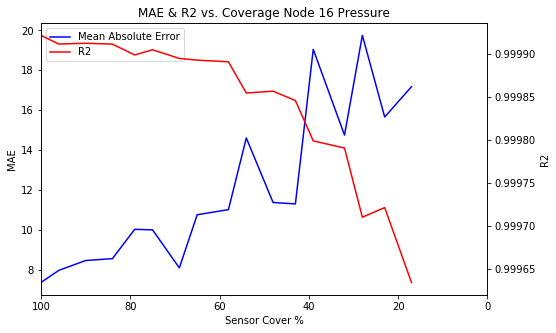

In [6]:
# Create the plot and specify the figure size
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the first line
ax1.plot(sensors_covered, maximum_MAE, 'b-', label='Mean Absolute Error')
ax1.set_xlabel('Sensor Cover %')
ax1.set_ylabel('MAE')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second line
ax2.plot(sensors_covered, R2_average, 'r-', label='R2')
ax2.set_ylabel('R2')

# Show legends for both lines
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
ax1.legend(lines, [line.get_label() for line in lines])

# Show the plot
plt.title("MAE & R2 vs. Coverage Node 16 Pressure")
plt.xlim([100, 0])
plt.savefig('/Users/alexellard/Downloads/MAER2Pressure.png')
plt.show()
